### Loading libraries

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)

── Attaching packages ────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ───────────────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.6      ✔ rsample      0.0.9 
✔ dials        0.0.9      ✔ tune         0.1.5 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ──────────────────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::la

### Utility functions

In [2]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

### Loading data

In [447]:
path <- ""

names <- read.table(paste(path, "spotify-names.txt", sep = ""),header = TRUE)
songs <- read.table(paste(path, "spotify-extr.txt", sep = ""),
                    sep = " ", header = TRUE) %>%
    as_tibble() %>%
    mutate(name = names$x,
           key = factor(key),
           mode = factor(mode, levels=c(0,1), labels=c('minor', 'major')),
           pop.class = factor(pop.class)) %>%
    relocate(c(pop.class, popularity)) %>%
    relocate(c(key, mode, name), .after=last_col())

songs.quant <- songs %>% select(popularity:tempo)

head(songs)

pop.class popularity valence year acousticness danceability duration energy
1 C         25         0.647   1975 0.4490       0.376        298840   0.827 
2 B         42         0.150   2008 0.8990       0.508        236800   0.169 
3 A         65         0.423   2007 0.0185       0.470        301093   0.878 
4 C         36         0.302   1995 0.0384       0.176        142200   0.980 
5 C         38         0.828   1994 0.5310       0.705        187800   0.625 
6 A         68         0.489   2018 0.3710       0.856        324189   0.694 
  instrumentalness liveness loudness speechiness tempo   key mode 
1 7.88e-03         0.466     -7.604  0.3990      170.475 B   major
2 1.12e-05         0.136    -11.332  0.0553      107.477 Ab  major
3 8.39e-02         0.276     -5.576  0.0377      150.093 B   minor
4 5.52e-01         0.237     -3.154  0.0721      172.566 B   major
5 7.73e-06         0.348    -11.963  0.0639       97.831 G   minor
6 0.00e+00         0.109     -4.393  0.1690      122.080 D   major
  name                            
1 William Tell Overture           
2 Everything I Know               
3 Rest My Chemistry               
4 Stutter                         
5 Wanna Do My Thing               
6 Mona Lisa (feat. Kendrick Lamar)

## Exploratory statistics

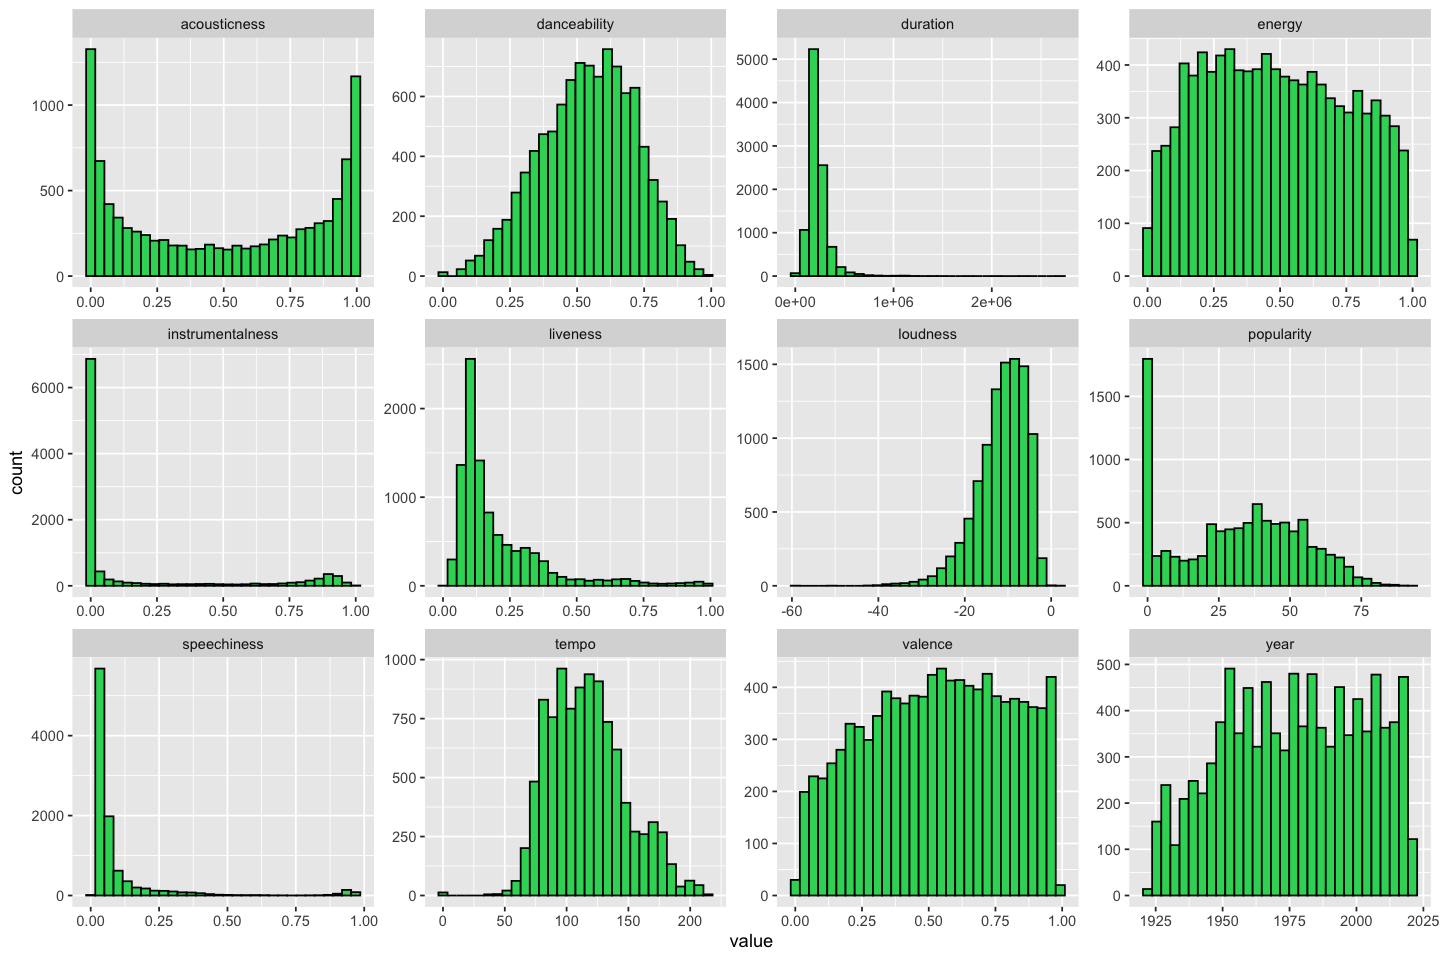

In [1142]:
fig(12,8)
songs.quant %>%
    pivot_longer(cols=everything(), names_to='variable', values_to='value') %>%
ggplot() +
    geom_histogram(aes(value), fill='#2FD565', color='#000000', bins=30) +
    facet_wrap(~variable, scales='free')

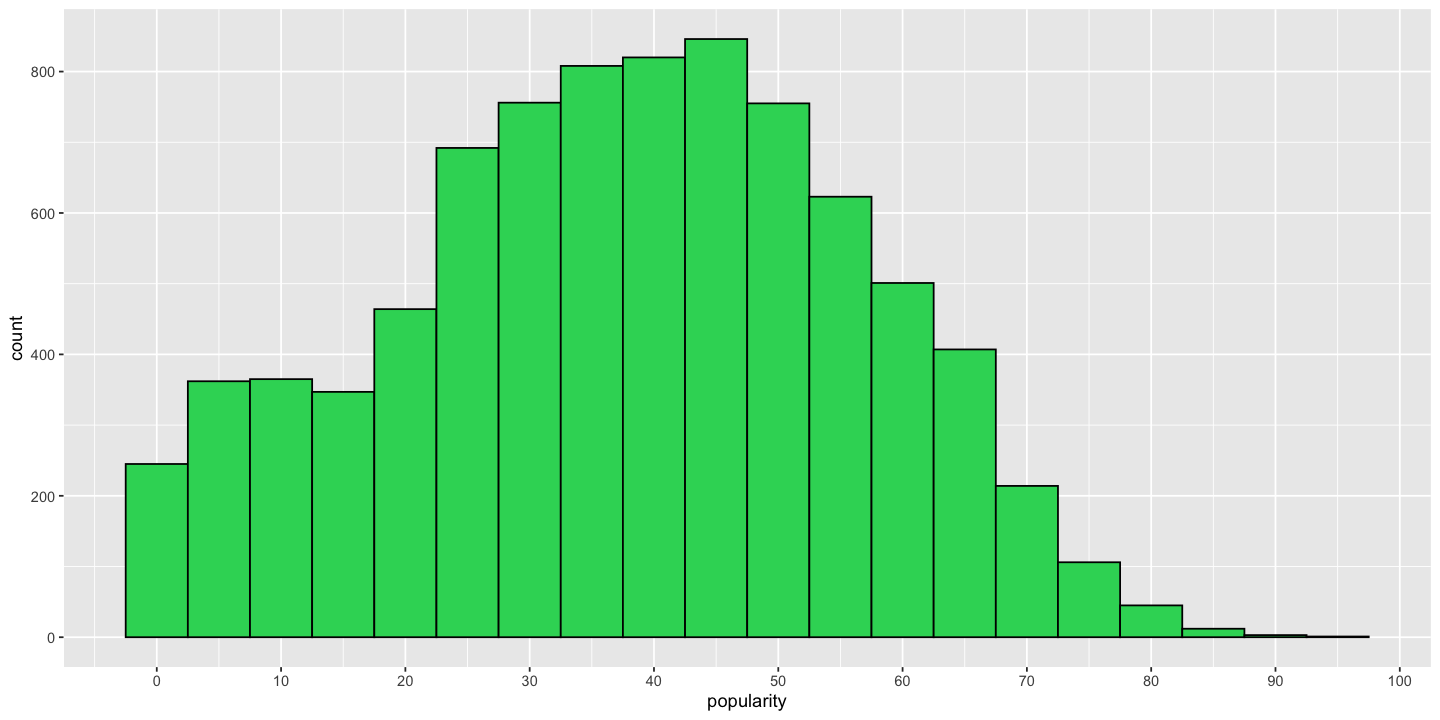

In [1146]:
fig(12,6)
songs %>%
    filter(popularity > 0) %>%
ggplot() +
    geom_histogram(aes(popularity), fill='#2FD565', color='#000000', binwidth = 5) +
    scale_x_continuous(breaks=seq(0,100, by=10))

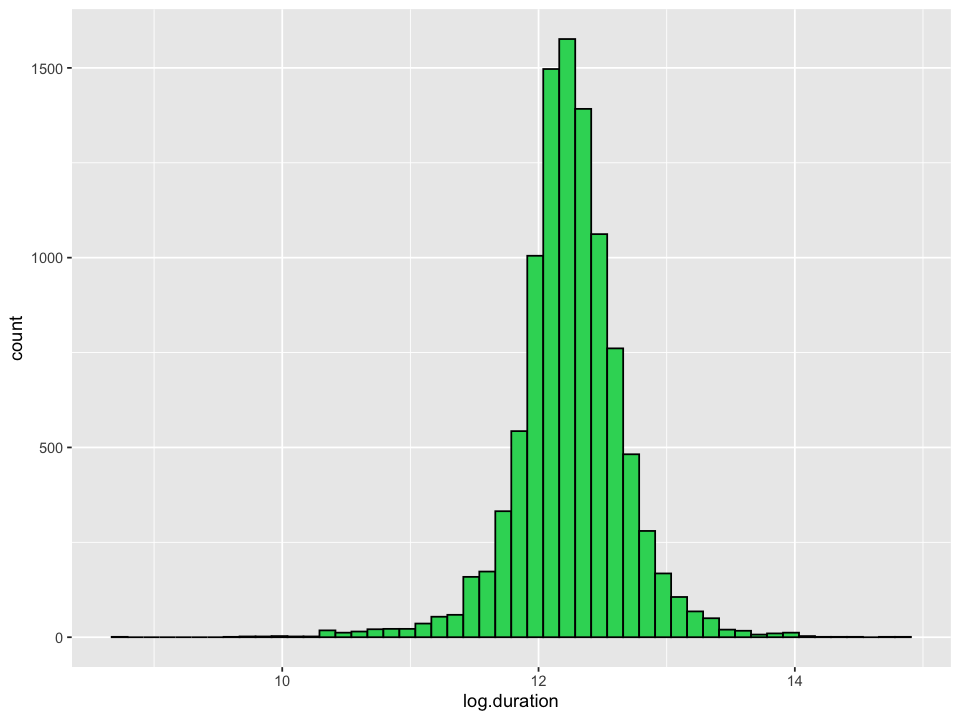

In [9]:
fig(8,6)
songs %>%
    mutate(log.duration=log(duration)) %>%
ggplot() +
    geom_histogram(aes(log.duration), fill='#2FD565', color='#000000', bins=50)

In [4]:
LOG_DURATION <- FALSE
if (!LOG_DURATION) {
    songs <- songs %>%
        mutate(duration=log(duration))
    LOG_DURATION <- TRUE
}

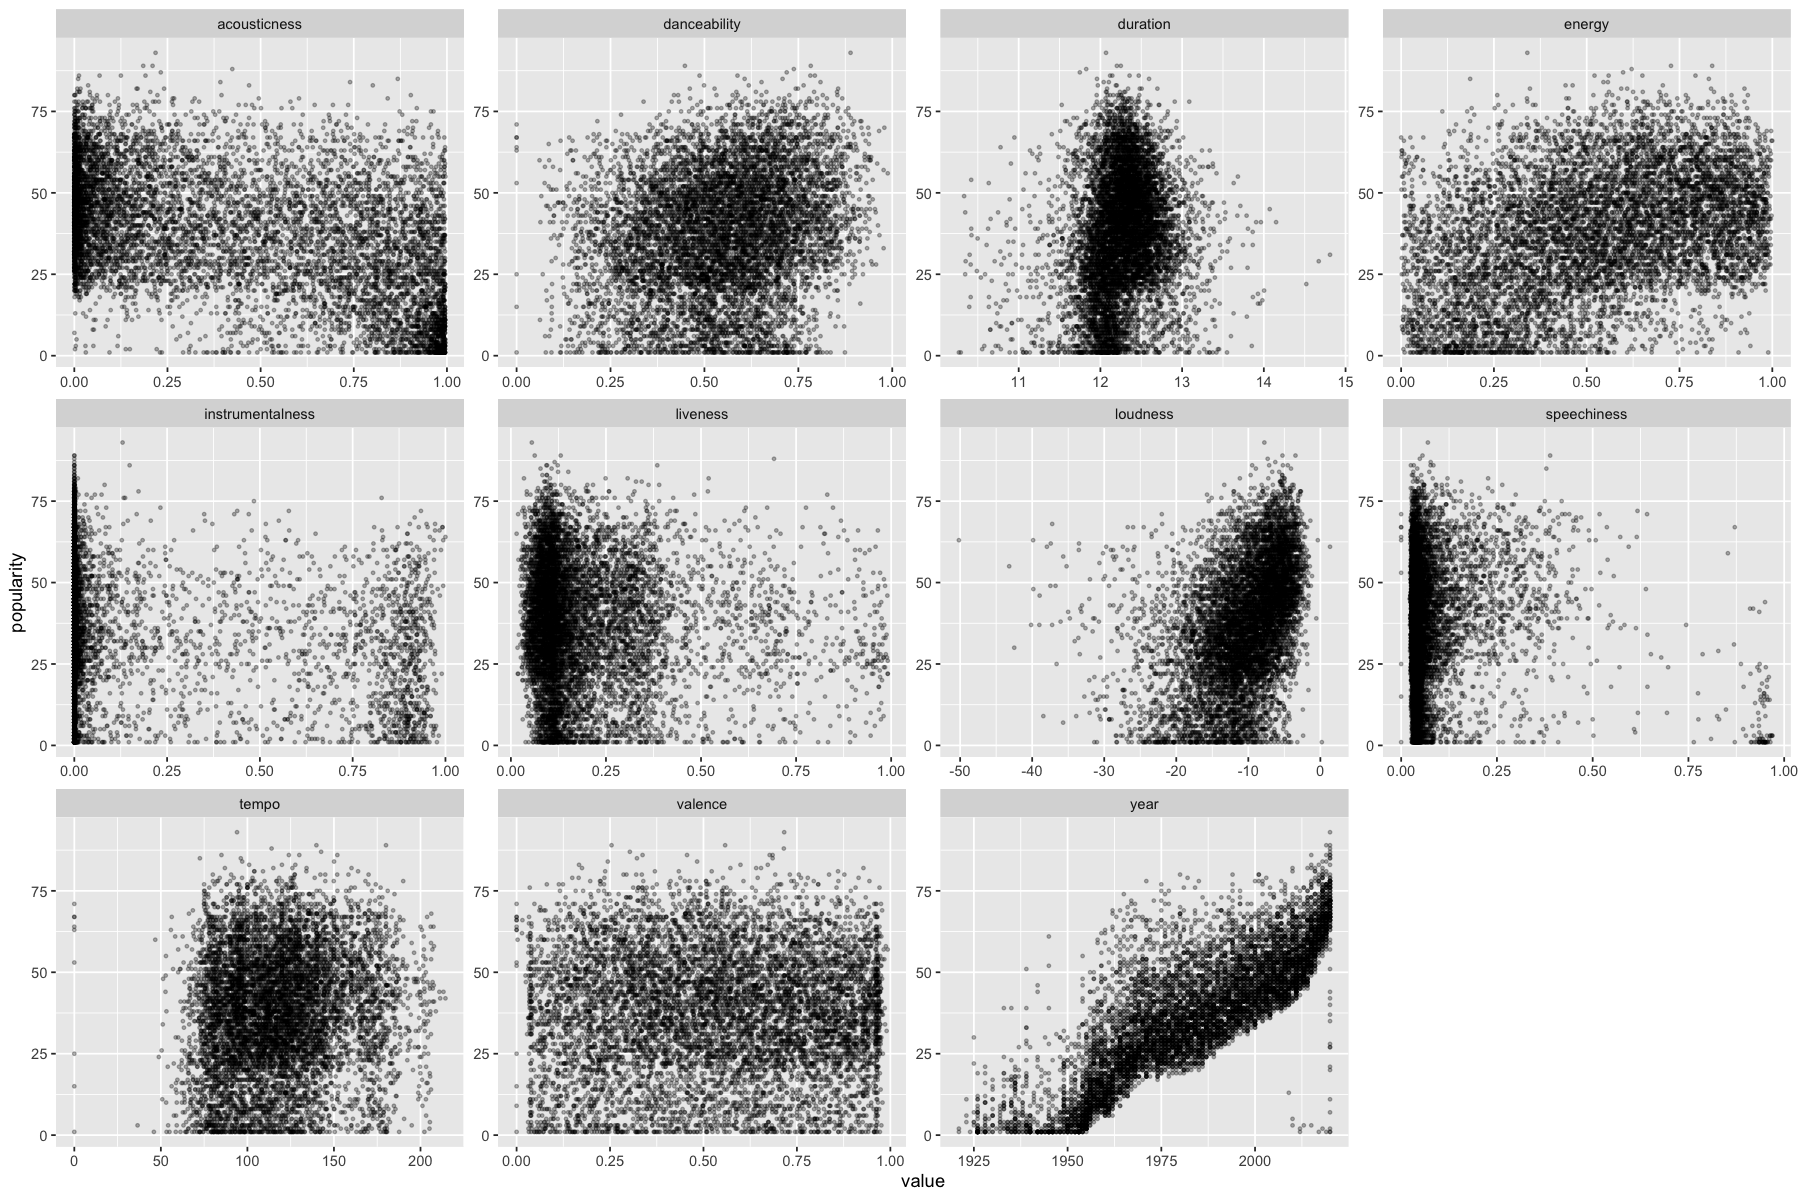

In [1147]:
fig(15,10)
songs.quant %>%
    filter(popularity>0) %>%
    mutate(duration=log(duration)) %>%
    pivot_longer(cols=!popularity, names_to='variable', values_to='value') %>%
ggplot() +
    geom_point(aes(value, popularity), size=.7, alpha=.3) + 
    facet_wrap(~variable, scales='free')

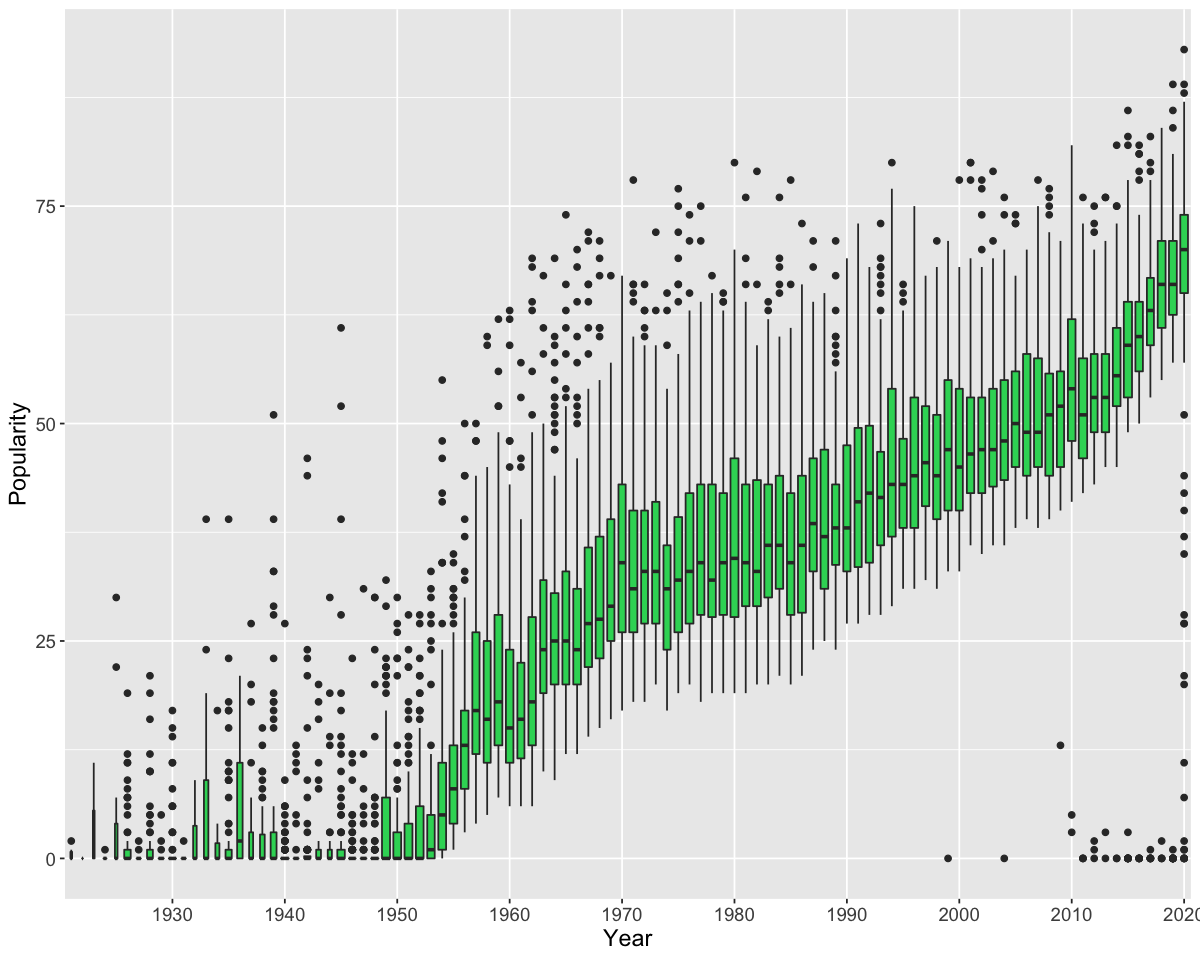

In [1148]:
fig(10,8)
songs %>%
ggplot(aes(year %>% factor(), popularity)) +
    geom_boxplot(fill='#2FD565', varwidth = TRUE) +
    scale_x_discrete(breaks=seq(1920, 2020, by=10), name='Year') +
    labs(y='Popularity') +
    theme(text=element_text(size=14))

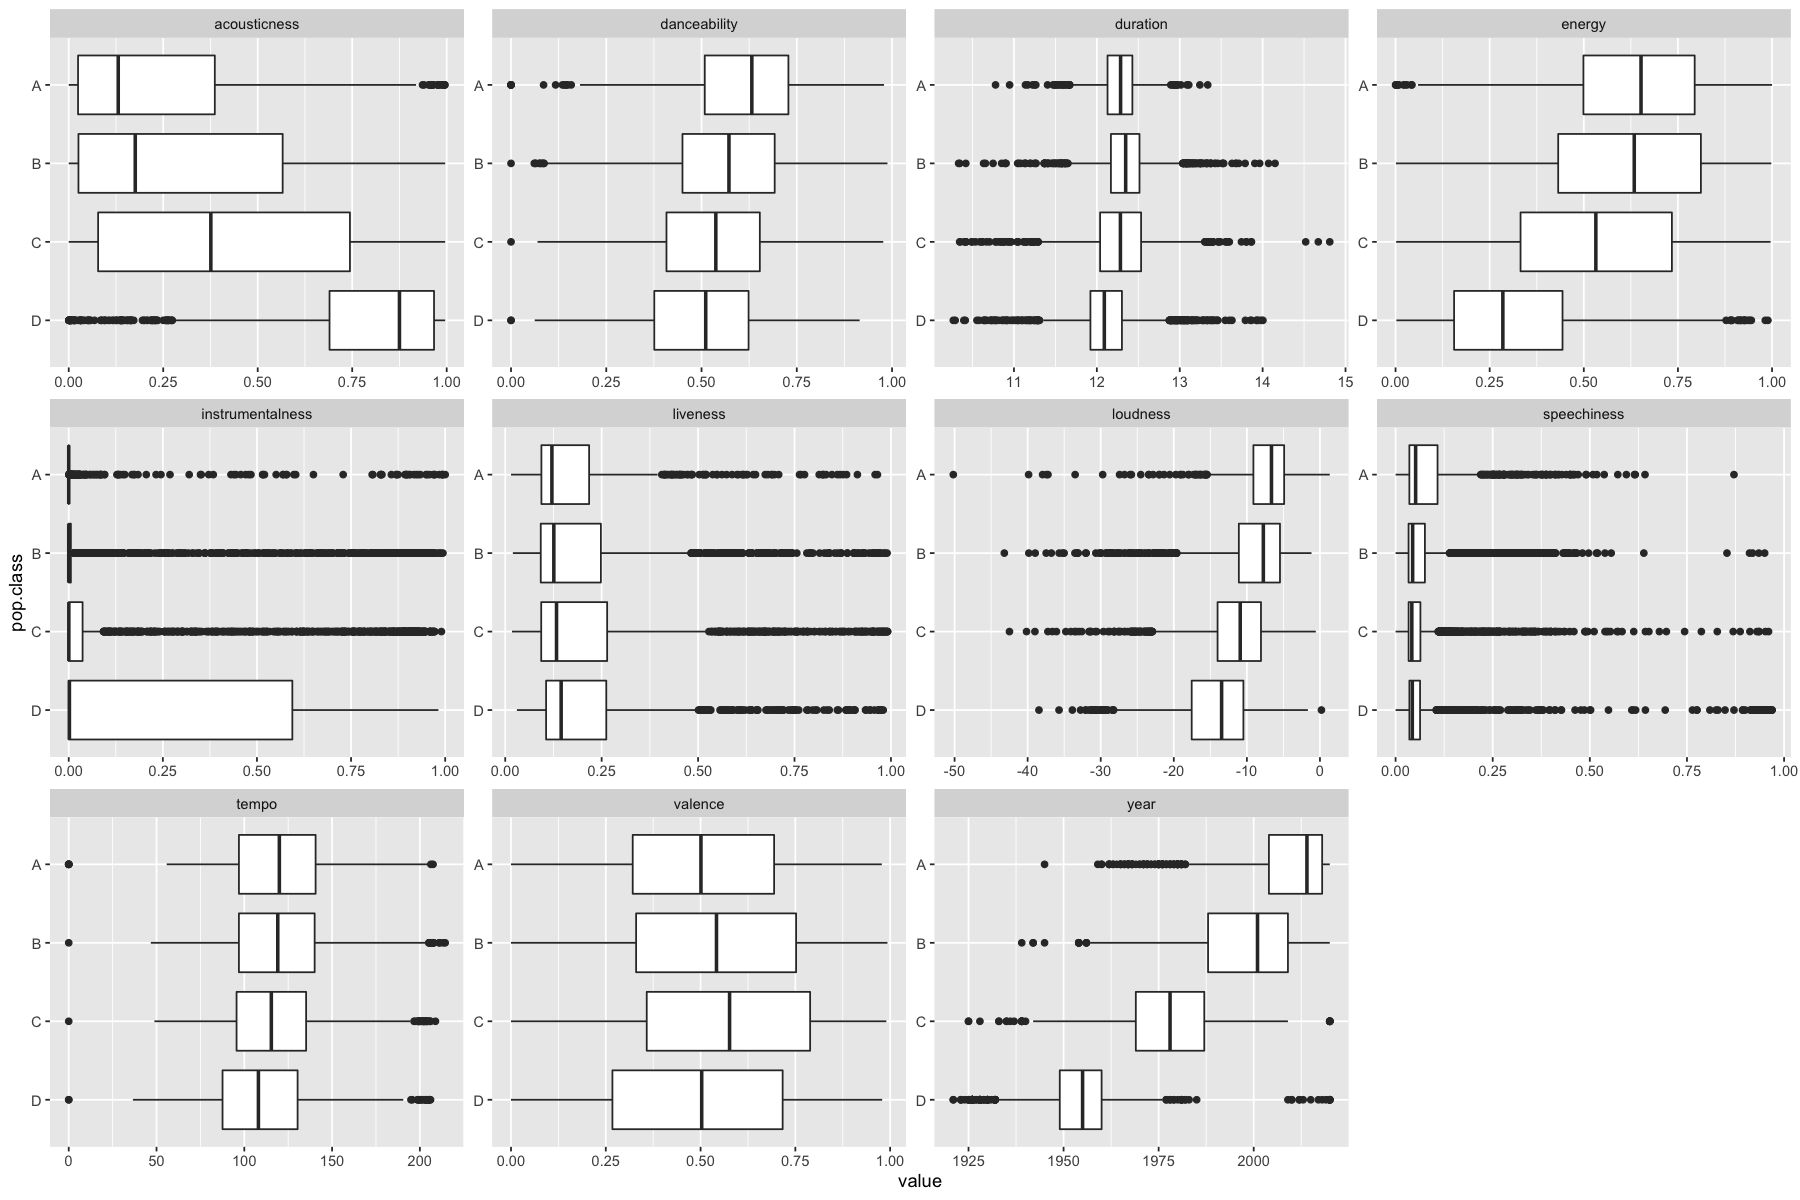

In [1149]:
fig(15,10)
songs %>%
    filter(popularity>0) %>%
    mutate(duration=log(duration)) %>%
    select(c(pop.class, valence:tempo)) %>%
    pivot_longer(cols=!pop.class, names_to='variable', values_to='value') %>%
ggplot() +
    #geom_jitter(aes(value, pop.class), size=.7, alpha=.3) + 
    geom_boxplot(aes(value, pop.class)) +
    facet_wrap(~variable, scales='free') +
    scale_y_discrete(limits=rev)

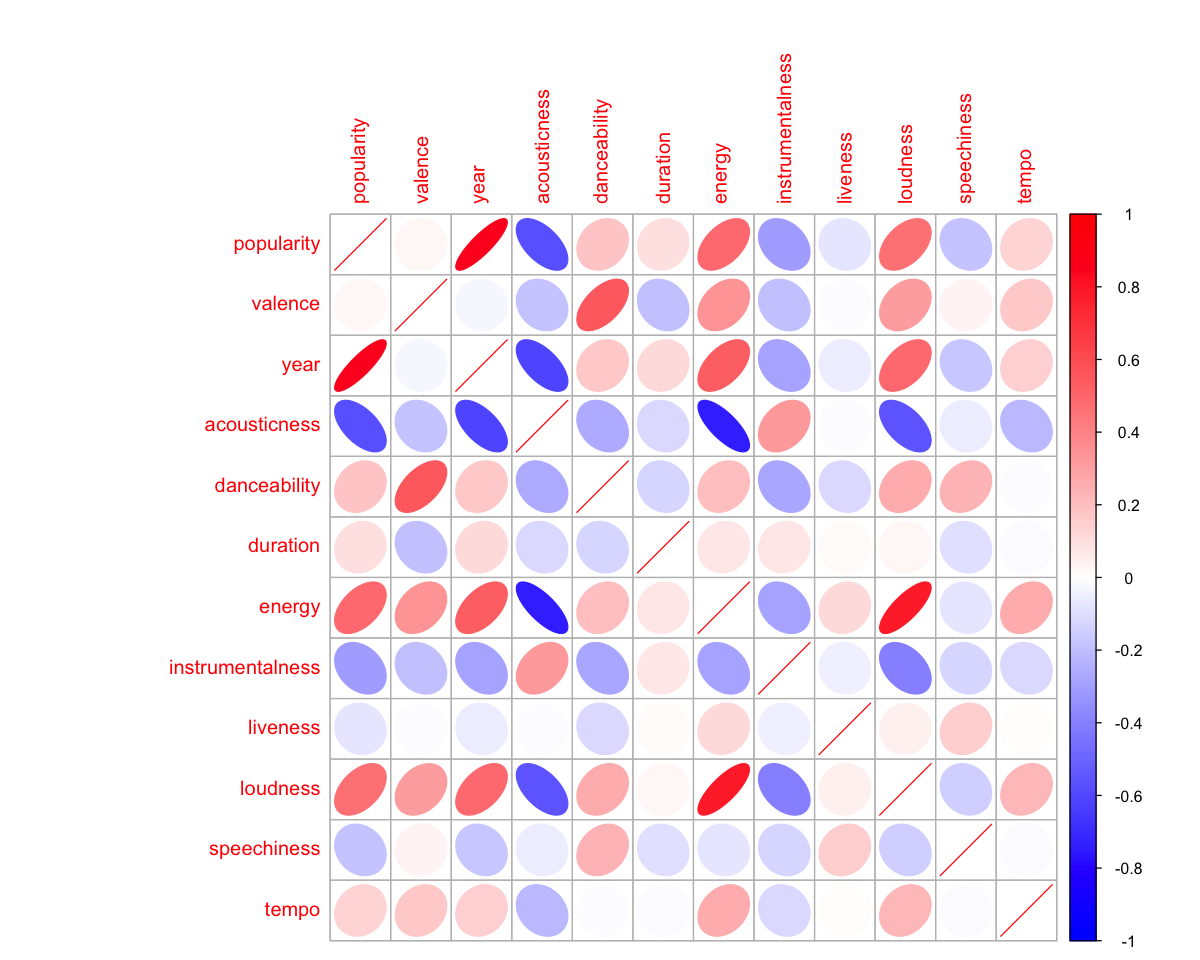

In [464]:
library(corrplot)
cormat <- cor(songs.quant)
corrplot(cormat, method="ellipse", col=colorRampPalette(c("blue", "white", "red"))(200))

In [ ]:
fig(8,6)
songs %>%
ggplot() +
    geom_boxplot(aes(x=reorder(key, -popularity, FUN=median), y=popularity), fill='#2FD565', color='#000000') +
    labs(x='Key', y='Popularity')


songs %>%
ggplot() +
    geom_bar(stat='count', aes(reorder(key, -popularity, FUN=median)), fill='#2FD565', color='#000000') +
    labs(x='Key', y='Count')

In [ ]:
fig(8,6)
songs %>%
ggplot() +
    geom_boxplot(aes(mode, popularity), fill='#2FD565', color='#000000') +
    labs(x='Mode', y='Popularity')

In [ ]:
library(ggmosaic)
songs %>%
ggplot() +
    geom_mosaic(aes(product(mode, key)), fill='#2FD565')

## Principal component analysis

In [ ]:
library(FactoMineR)
library(factoextra)
res.pca <- songs.quant %>% 
    select(!popularity) %>% 
    PCA(ncp=11)

In [ ]:
fig(12,5)


pc_eig <- tibble(pc=c(1:11), eig=res.pca$eig[1:11,2], cumeig=res.pca$eig[1:11,3])
g1 <- pc_eig %>%
ggplot(aes(pc, eig)) + 
    geom_bar(stat="identity", fill='#2FD565') +
    geom_line() + 
    geom_point() +
    scale_x_continuous(breaks=c(1:11), labels=paste('PC', c(1:11), sep=''), minor_breaks=NULL) +
    labs(x='', y='Percentage of variance', title='Percentage of variance by principal component') +
    annotate('text', x=c(1:11)+.4, y=pc_eig$eig+1.1, label=paste(round(pc_eig$eig,1), '%', sep='')) +
    theme(text=element_text(size=14))

g2 <- pc_eig %>%
ggplot(aes(pc, cumeig)) + 
    geom_bar(stat="identity", fill='#2FD565') +
    geom_line() + 
    geom_point() +
    scale_x_continuous(breaks=c(1:11), labels=paste('PC', c(1:11), sep=''), minor_breaks=NULL) +
    labs(x='', y='Percentage of variance', title='Cumulative percentage of variance') +
    #annotate('text', x=c(1:11)-.1, y=pc_eig$cumeig+6, label=paste(round(pc_eig$cumeig,1), '%', sep='')) +
    theme(text=element_text(size=14))

grid.arrange(g1, g2, nrow=1)

In [ ]:
pc_eig

In [ ]:
fig(8,6)
fviz_pca_var(res.pca, col.var="contrib") +
    scale_color_gradient(low="black", high="green") +
    labs(x='PC1 (31.3%)', y='PC2 (14.9%)', color='Contribution') +
    guides(color='none') +
    theme_gray() + theme(text=element_text(size=14))

In [ ]:
name_func <- function(name) {
    paste('PC', substring(name, first=5), sep='')
}

pca.ind <- as_tibble(res.pca$ind$coord) %>%
    rename_with(name_func, everything()) %>%
    mutate(pop.class=songs$pop.class)

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}
colors <- gg_color_hue(4)

fig(10,8)
ggplot(pca.ind) + 
    geom_point(aes(x=PC1, y=PC2, color=pop.class), alpha=.5, shape=19) +
    scale_x_continuous(limits=c(-6,4)) +
    scale_y_continuous(limits=c(-5,5)) +
    guides(color = guide_legend(override.aes = list(size = 10))) +
    labs(x='PC1 (31.3%)', y='PC2 (14.9%)', color="Popularity class") +
    theme(text=element_text(size=14))

# Classification models

In [471]:
library(rsample)

train_ratio <- .8
data_split <- songs %>%
    initial_split(strata = pop.class, prop = train_ratio)

songs_train <- training(data_split) %>%
    select(!c(popularity, name))

songs_test  <- testing(data_split) %>%
    select(!c(popularity, name))

In [472]:
songs_cv <- rsample::vfold_cv(songs_train, v=10)

In [989]:
pop_count <- songs_test %>%
    group_by(pop.class) %>%
    count() %>%
    ungroup() %>%
    .[c(rep(1, 4), rep(2, 4), rep(3, 4), rep(4, 4)),]

plot_conf_mat <- function(model_results) {
    
    conf_mat <- model_results %>%
        group_by(pop.class, .pred_class) %>%
        count(.pred_class, pop.class, .drop=FALSE) %>%
        ungroup() %>%
        mutate(pop_count=pop_count$n) %>%
        mutate(freq=n / pop_count) %>%
        mutate(correct=ifelse(.pred_class==pop.class, 1, -1))
    
    cell_labs <- paste(round(100*conf_mat$freq), '%\n(N=', conf_mat$n, ')', sep='')
    cell_labs <- paste(conf_mat$n, '\n(',round(100*conf_mat$freq), '%)', sep='')
    
    conf_mat %>%
    ggplot(aes(.pred_class, pop.class)) +
    geom_tile(aes(fill=freq*correct), color='black', size=.3) +
    geom_text(aes(label=cell_labs), color='black', size=8) +
    scale_fill_gradient2(low='pink', mid='white', high='#2FD565') +
    scale_y_discrete(limits=rev, name='Popularity class') +
    scale_x_discrete(position='top', name='Predicted class') +
    coord_equal() +
    theme_minimal() +
    theme(legend.position = "none",
          text=element_text(size=26),
          axis.text=element_text(size=30))
}

## Logistic regression

In [473]:
library(glmnet)

### Without regularization

In [494]:
log_reg <- multinom_reg(penalty = 0) %>%
    set_engine('glmnet')

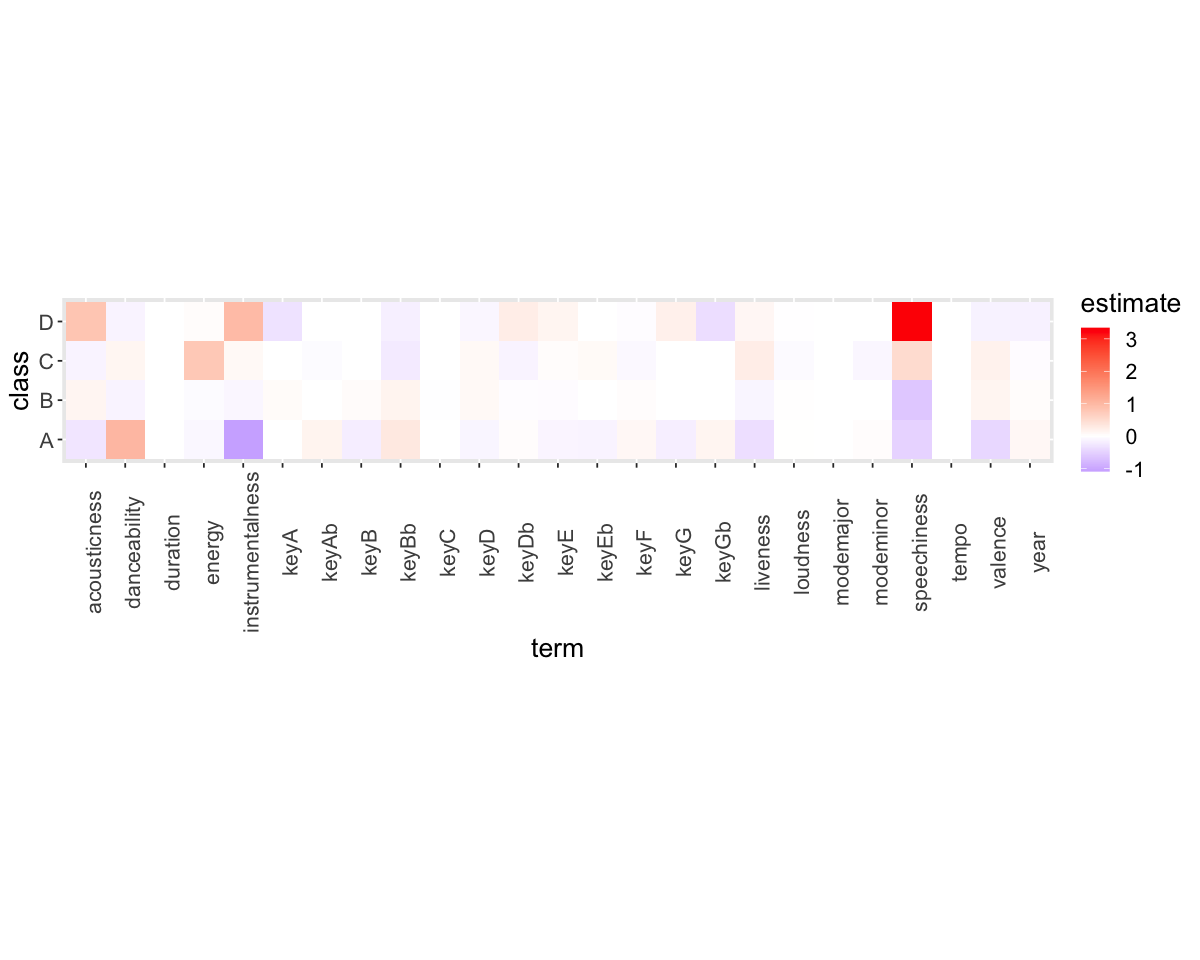

In [874]:
log_reg_fit <-
    log_reg %>%
    fit(pop.class ~ ., 
        data=songs_train)


tidy(log_reg_fit) %>% 
    filter(term != '(Intercept)') %>%
ggplot(aes(term, class)) +
    geom_tile(aes(fill=estimate)) +
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high = "red",
                         midpoint = 0) +
    coord_equal() +
    theme(text=element_text(size=16), axis.text.x = element_text(angle = 90))

In [63]:
log_reg_results <- 
  songs_test %>%
  select(pop.class) %>%
  bind_cols(
    predict(log_reg_fit, new_data = songs_test %>% select(-pop.class))
  )

.metric  .estimator .estimate
1 accuracy multiclass 0.7193597

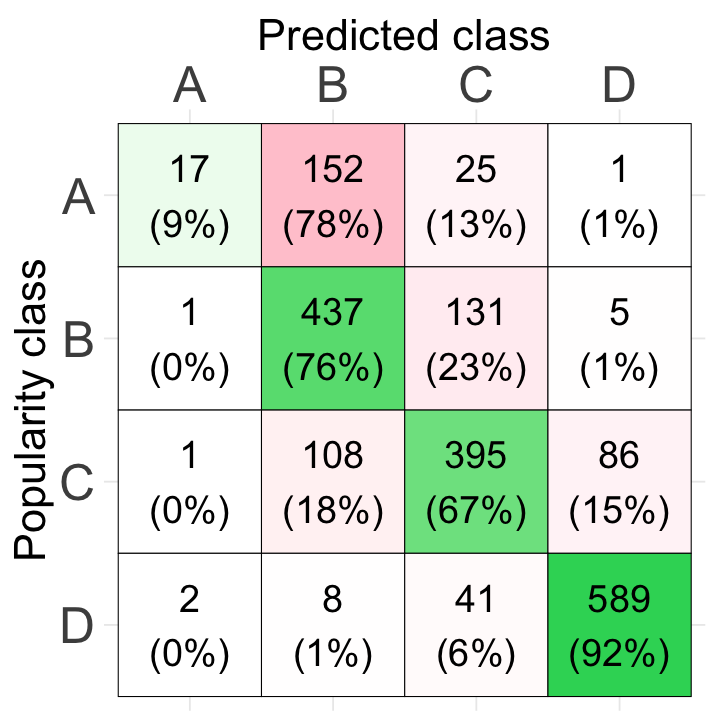

In [1234]:
plot_conf_mat(log_reg_results)

log_reg_results %>%
    yardstick::accuracy(pop.class, .pred_class)

### With regularization

In [1025]:
#log_reg_grid <- tibble(penalty = 10^seq(-3, 0, length.out = 30))
#log_reg_grid <- tibble(penalty = 10^seq(-3, -.3, length.out = 30))
log_reg_grid <- expand.grid(penalty = 10^seq(-3, 0, length.out = 20), mixture=seq(0,1, length = 5))

log_reg_rec <- recipe(pop.class ~ ., data = songs_train) %>%
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_dummy(all_nominal(), -all_outcomes())
    step_

log_reg_mod <- multinom_reg(penalty = tune(), mixture = tune()) %>%
    set_engine("glmnet")

log_reg_wf <- workflow() %>%
    add_recipe(log_reg_rec) %>%
    add_model(log_reg_mod)

In [1026]:
log_reg_fit <- log_reg_wf %>%
    tune_grid(
        resamples = songs_cv,
        grid = log_reg_grid,
        metrics = metric_set(accuracy, roc_auc),
        control = control_grid(verbose = TRUE)
    )

i Fold01: preprocessor 1/1

✓ Fold01: preprocessor 1/1

i Fold01: preprocessor 1/1, model 1/5

✓ Fold01: preprocessor 1/1, model 1/5

i Fold01: preprocessor 1/1, model 1/5 (predictions)

i Fold01: preprocessor 1/1, model 2/5

✓ Fold01: preprocessor 1/1, model 2/5

i Fold01: preprocessor 1/1, model 2/5 (predictions)

i Fold01: preprocessor 1/1, model 3/5

✓ Fold01: preprocessor 1/1, model 3/5

i Fold01: preprocessor 1/1, model 3/5 (predictions)

i Fold01: preprocessor 1/1, model 4/5

✓ Fold01: preprocessor 1/1, model 4/5

i Fold01: preprocessor 1/1, model 4/5 (predictions)

i Fold01: preprocessor 1/1, model 5/5

✓ Fold01: preprocessor 1/1, model 5/5

i Fold01: preprocessor 1/1, model 5/5 (predictions)

i Fold02: preprocessor 1/1

✓ Fold02: preprocessor 1/1

i Fold02: preprocessor 1/1, model 1/5

✓ Fold02: preprocessor 1/1, model 1/5

i Fold02: preprocessor 1/1, model 1/5 (predictions)

i Fold02: preprocessor 1/1, model 2/5

✓ Fold02: preprocessor 1/1, model 2/5

i Fold02: preprocessor 1

i Fold08: preprocessor 1/1, model 5/5

✓ Fold08: preprocessor 1/1, model 5/5

i Fold08: preprocessor 1/1, model 5/5 (predictions)

i Fold09: preprocessor 1/1

✓ Fold09: preprocessor 1/1

i Fold09: preprocessor 1/1, model 1/5

✓ Fold09: preprocessor 1/1, model 1/5

i Fold09: preprocessor 1/1, model 1/5 (predictions)

i Fold09: preprocessor 1/1, model 2/5

✓ Fold09: preprocessor 1/1, model 2/5

i Fold09: preprocessor 1/1, model 2/5 (predictions)

i Fold09: preprocessor 1/1, model 3/5

✓ Fold09: preprocessor 1/1, model 3/5

i Fold09: preprocessor 1/1, model 3/5 (predictions)

i Fold09: preprocessor 1/1, model 4/5

✓ Fold09: preprocessor 1/1, model 4/5

i Fold09: preprocessor 1/1, model 4/5 (predictions)

i Fold09: preprocessor 1/1, model 5/5

✓ Fold09: preprocessor 1/1, model 5/5

i Fold09: preprocessor 1/1, model 5/5 (predictions)

i Fold10: preprocessor 1/1

✓ Fold10: preprocessor 1/1

i Fold10: preprocessor 1/1, model 1/5

✓ Fold10: preprocessor 1/1, model 1/5

i Fold10: preprocessor 1

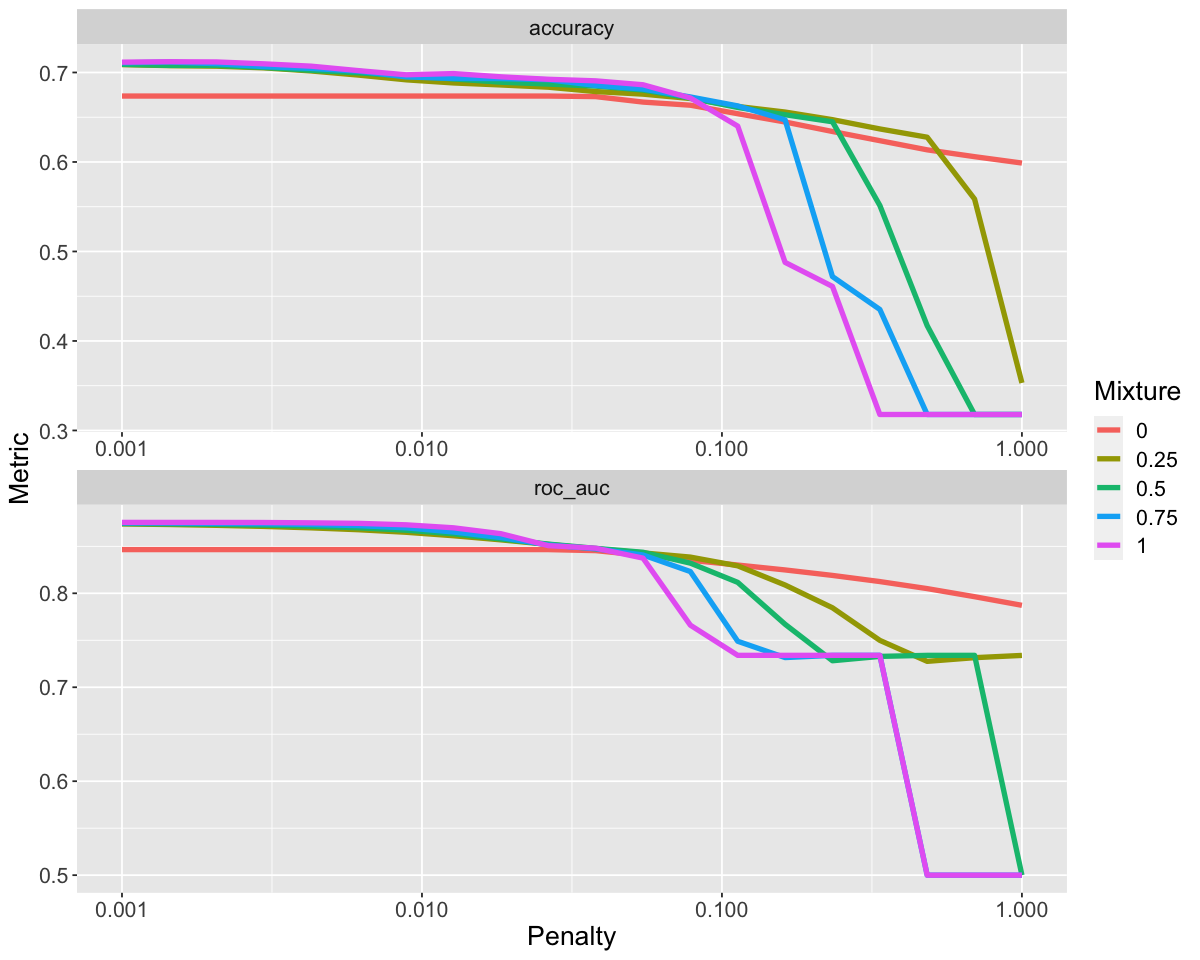

In [1034]:
fig(10,8)
log_reg_fit %>%
    collect_metrics() %>%
    ggplot(aes(penalty, mean, color = factor(mixture))) +
    #geom_errorbar(aes(ymin = mean - std_err,
    #                  ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Penalty', y='Metric', color='Mixture') +
    theme(text=element_text(size=16))

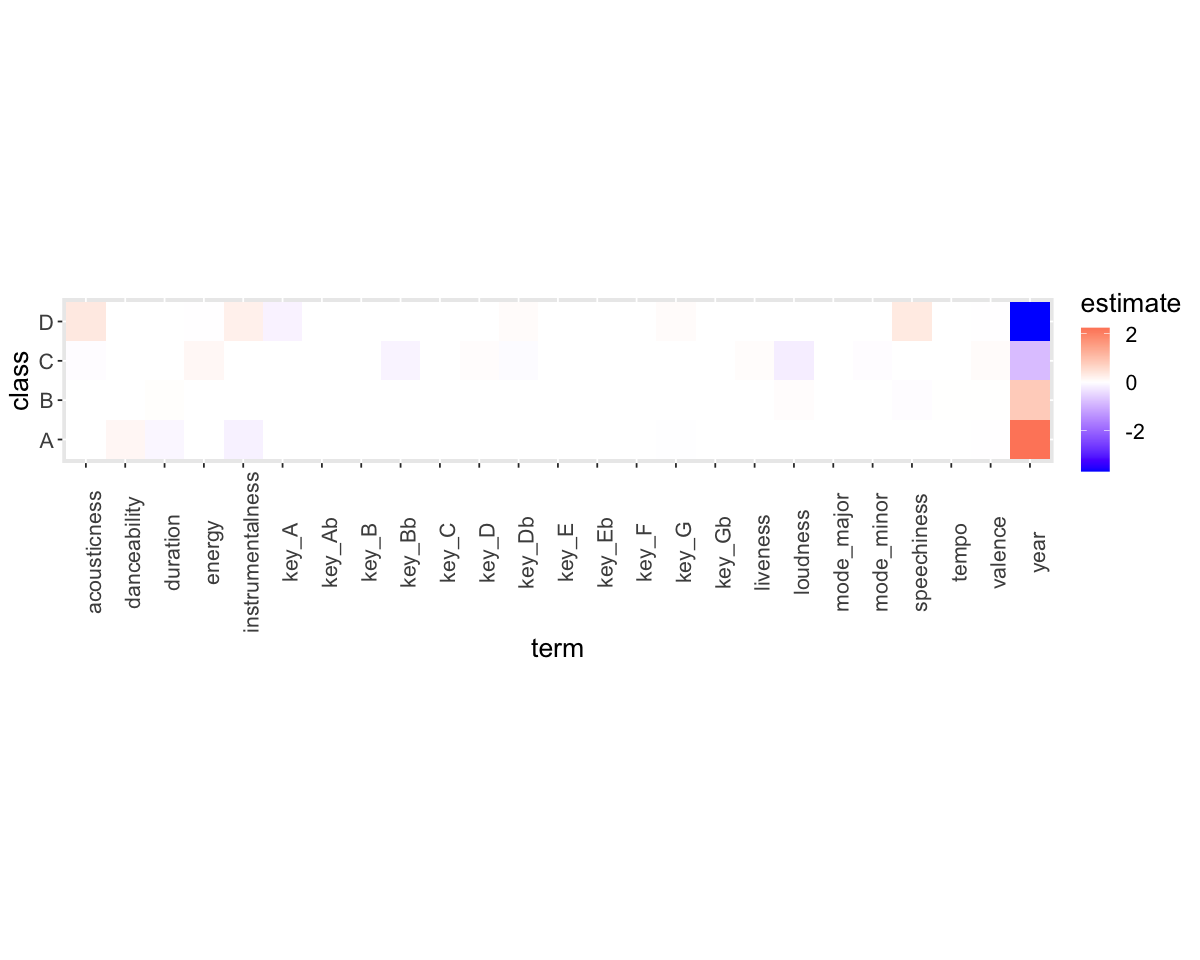

In [1037]:
log_reg_best <- log_reg_fit %>%
    select_by_one_std_err(metric="accuracy", desc(penalty))
    #select_best(metric="accuracy")
    #select_by_one_std_err(metric="rmse", penalty)

log_reg_wf %>% 
    finalize_workflow(log_reg_best) %>%
    fit(songs_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    filter(term != '(Intercept)') %>%
    #select(term, estimate) %>%
    #arrange(desc(abs(estimate))) %>%
ggplot(aes(term, class)) +
    geom_tile(aes(fill=estimate)) +
    scale_fill_gradient2(low = "blue",
                           mid = "white",
                           high = "red",
                           midpoint = 0) +
    coord_equal() +
    theme(text=element_text(size=16), axis.text.x = element_text(angle = 90))

In [1046]:
log_reg_wf %>% 
    finalize_workflow(log_reg_best) %>%
    fit(songs_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    filter(abs(estimate) > 0) %>%
    filter(term != '(Intercept)')

class term             estimate      penalty    
1  A     valence          -9.697497e-03 0.004281332
2  A     year              2.233147e+00 0.004281332
3  A     acousticness     -6.145052e-03 0.004281332
4  A     danceability      1.337385e-01 0.004281332
5  A     duration         -1.042012e-01 0.004281332
6  A     instrumentalness -1.767600e-01 0.004281332
7  A     liveness         -1.553846e-04 0.004281332
8  A     key_Bb            6.064392e-03 0.004281332
9  A     key_G            -1.631052e-02 0.004281332
10 B     valence           8.486441e-03 0.004281332
11 B     year              8.331504e-01 0.004281332
12 B     acousticness      6.145052e-03 0.004281332
13 B     duration          2.259224e-02 0.004281332
14 B     loudness          3.291215e-02 0.004281332
15 B     speechiness      -3.238414e-02 0.004281332
16 B     tempo             8.341384e-03 0.004281332
17 C     valence           5.051200e-02 0.004281332
18 C     year             -8.331504e-01 0.004281332
19 C     acousticness     -2.899271e-02 0.004281332
20 C     energy            1.139452e-01 0.004281332
21 C     liveness          3.706725e-02 0.004281332
22 C     loudness         -2.212665e-01 0.004281332
23 C     tempo            -5.034691e-03 0.004281332
24 C     key_Bb           -1.332859e-01 0.004281332
25 C     key_D             3.460026e-02 0.004281332
26 C     key_Db           -5.254619e-02 0.004281332
27 C     mode_minor       -2.641894e-02 0.004281332
28 C     mode_major        1.568811e-16 0.004281332
29 D     valence          -9.432408e-03 0.004281332
30 D     year             -3.695032e+00 0.004281332
31 D     acousticness      3.497371e-01 0.004281332
32 D     energy           -1.048705e-02 0.004281332
33 D     instrumentalness  2.306825e-01 0.004281332
34 D     speechiness       3.342593e-01 0.004281332
35 D     key_A            -1.493532e-01 0.004281332
36 D     key_Db            5.978510e-02 0.004281332
37 D     key_G             5.200531e-02 0.004281332

In [454]:
library(xtable)
options(xtable.floating = FALSE)
options(xtable.timestamp = "")
lin_reg_wf %>% 
    finalize_workflow(lin_reg_best) %>%
    fit(songs_reg_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    filter(abs(estimate) > 0) %>%
    select(term, estimate) %>%
    xtable(type = "latex") %>%
print(file = "lm.tex")

In [1052]:
log_reg_best_fit <- log_reg_wf %>%
    finalize_workflow(log_reg_best) %>%
    fit(data=songs_train)

log_reg_results <- log_reg_best_fit %>%
    predict(new_data = songs_test) %>%
    bind_cols(songs_test, .) %>%
    select(pop.class, .pred_class)

.metric  .estimator .estimate
1 accuracy multiclass 0.7193597

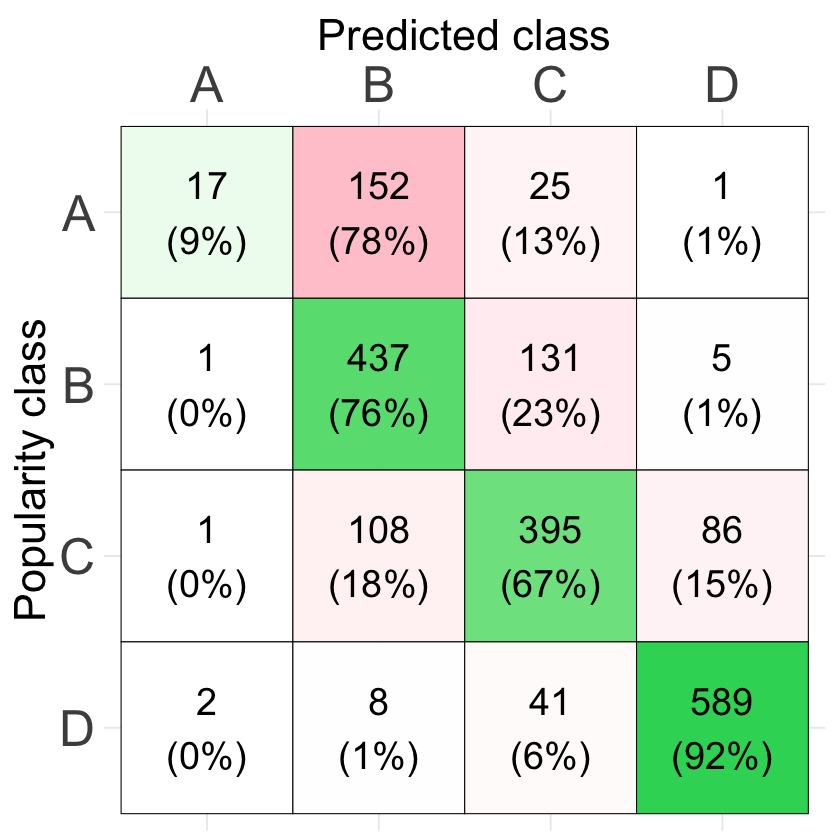

In [1224]:
plot_conf_mat(log_reg_results)

log_reg_results %>%
    yardstick::accuracy(pop.class, .pred_class)

## K-nearest neighbours

In [852]:
knn_grid <- tibble(neighbors = seq(10, 70, by=5))

knn_rec <- recipe(pop.class ~ ., data = songs_train) %>%
    step_dummy(all_nominal(), -all_outcomes())

knn_mod <- nearest_neighbor(neighbors=tune()) %>%
    set_mode("classification") %>%
    set_engine("kknn")

knn_wf <- workflow() %>%
    add_recipe(knn_rec) %>%
    add_model(knn_mod)

In [853]:
knn_fit <- knn_wf %>%
    tune_grid(
        resamples = songs_cv,
        grid = knn_grid
    )

In [854]:
knn_fit %>%
    collect_metrics()

neighbors .metric  .estimator mean      n  std_err     .config              
1  10        accuracy multiclass 0.5991748 10 0.005345034 Preprocessor1_Model01
2  10        roc_auc  hand_till  0.7993610 10 0.004521848 Preprocessor1_Model01
3  15        accuracy multiclass 0.6080493 10 0.005235175 Preprocessor1_Model02
4  15        roc_auc  hand_till  0.8086337 10 0.003778629 Preprocessor1_Model02
5  20        accuracy multiclass 0.6116745 10 0.006507547 Preprocessor1_Model03
6  20        roc_auc  hand_till  0.8128182 10 0.003481732 Preprocessor1_Model03
7  25        accuracy multiclass 0.6136748 10 0.006184599 Preprocessor1_Model04
8  25        roc_auc  hand_till  0.8156827 10 0.003251981 Preprocessor1_Model04
9  30        accuracy multiclass 0.6170493 10 0.005285209 Preprocessor1_Model05
10 30        roc_auc  hand_till  0.8172319 10 0.003093808 Preprocessor1_Model05
11 35        accuracy multiclass 0.6186737 10 0.005406499 Preprocessor1_Model06
12 35        roc_auc  hand_till  0.8179315 10 0.002941546 Preprocessor1_Model06
13 40        accuracy multiclass 0.6174243 10 0.005498151 Preprocessor1_Model07
14 40        roc_auc  hand_till  0.8183831 10 0.002806191 Preprocessor1_Model07
15 45        accuracy multiclass 0.6150492 10 0.005181822 Preprocessor1_Model08
16 45        roc_auc  hand_till  0.8186627 10 0.002719376 Preprocessor1_Model08
17 50        accuracy multiclass 0.6150488 10 0.004457028 Preprocessor1_Model09
18 50        roc_auc  hand_till  0.8187018 10 0.002655196 Preprocessor1_Model09
19 55        accuracy multiclass 0.6131735 10 0.003439635 Preprocessor1_Model10
20 55        roc_auc  hand_till  0.8187653 10 0.002635782 Preprocessor1_Model10
21 60        accuracy multiclass 0.6117987 10 0.004239869 Preprocessor1_Model11
22 60        roc_auc  hand_till  0.8186422 10 0.002632207 Preprocessor1_Model11
23 65        accuracy multiclass 0.6111735 10 0.004388102 Preprocessor1_Model12
24 65        roc_auc  hand_till  0.8183516 10 0.002599946 Preprocessor1_Model12
25 70        accuracy multiclass 0.6112988 10 0.004299092 Preprocessor1_Model13
26 70        roc_auc  hand_till  0.8180707 10 0.002559403 Preprocessor1_Model13

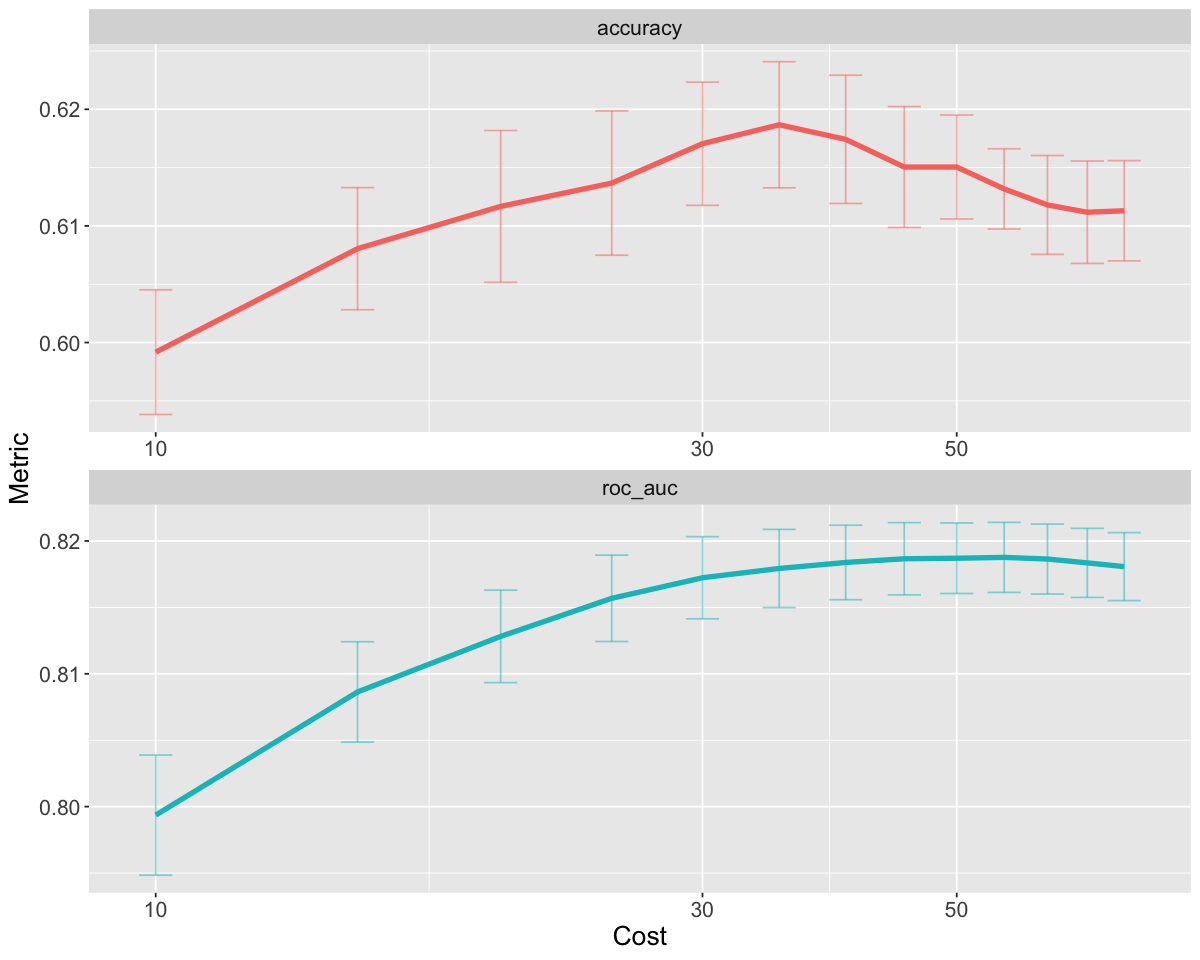

In [855]:
fig(10,8)
knn_fit %>%
    collect_metrics() %>%
    ggplot(aes(neighbors, mean, color = .metric)) +
    geom_errorbar(aes(ymin = mean - std_err,
                      ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Cost', y='Metric') +
    theme(legend.position = "none",
          text=element_text(size=16))

In [918]:
knn_best <- knn_fit %>%
    #select_by_one_std_err(metric="accuracy", desc(cost_complexity))
    select_best(metric="accuracy")
    #select_by_one_std_err(metric="rmse", penalty)

In [454]:
library(xtable)
options(xtable.floating = FALSE)
options(xtable.timestamp = "")
lin_reg_wf %>% 
    finalize_workflow(lin_reg_best) %>%
    fit(songs_reg_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    filter(abs(estimate) > 0) %>%
    select(term, estimate) %>%
    xtable(type = "latex") %>%
print(file = "lm.tex")

In [919]:
knn_best_fit <- knn_wf %>% 
    finalize_workflow(knn_best) %>%
    fit(data=songs_train)

knn_results <- knn_best_fit %>%
    predict(new_data = songs_test) %>%
    bind_cols(songs_test, .) %>%
    select(pop.class, .pred_class)

.metric  .estimator .estimate
1 accuracy multiclass 0.6363182

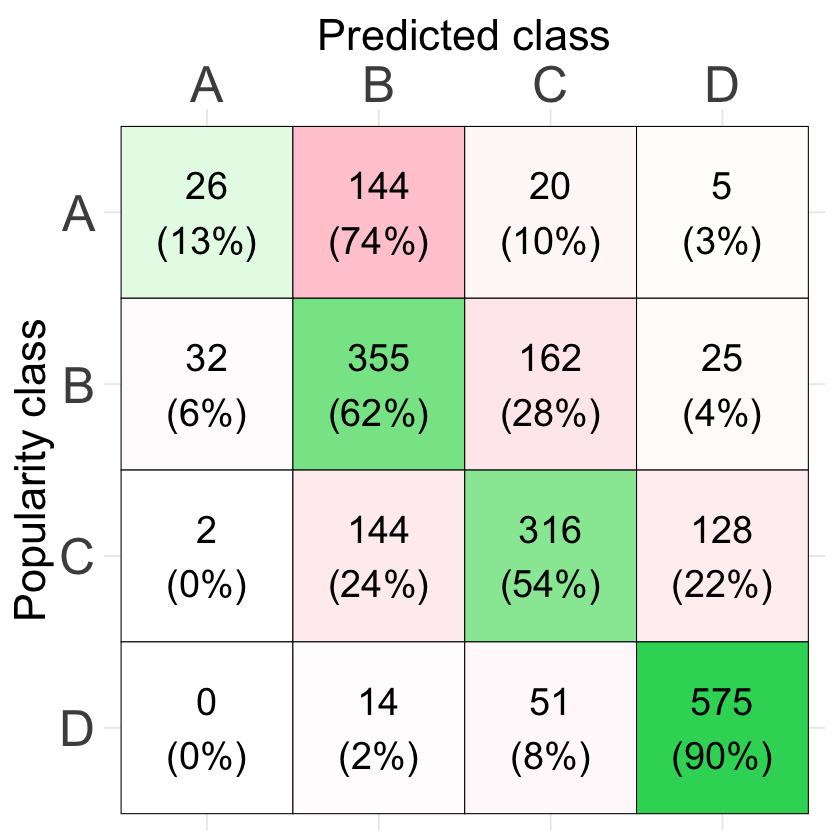

In [1225]:
plot_conf_mat(knn_results)

knn_results %>%
    yardstick::accuracy(pop.class, .pred_class)

## SMV

### Linear kernel

In [1054]:
svm_lin_grid <- tibble(cost = 10^seq(-3,1, length.out = 10))

svm_lin_rec <- recipe(pop.class ~ ., data = songs_train) %>%
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_select(-all_nominal_predictors())
    #step_dummy(all_nominal(), -all_outcomes())

svm_lin_mod <- svm_poly(degree=1, cost=tune()) %>%
    set_mode("classification") %>%
    set_engine("kernlab")

svm_lin_wf <- workflow() %>%
    add_recipe(svm_lin_rec) %>%
    add_model(svm_lin_mod)

In [1055]:
svm_lin_fit <- svm_lin_wf %>%
    tune_grid(
        resamples = songs_cv,
        grid = svm_lin_grid,
        control = control_grid(verbose = TRUE)
    )

i Fold01: preprocessor 1/1

✓ Fold01: preprocessor 1/1

i Fold01: preprocessor 1/1, model 1/10

✓ Fold01: preprocessor 1/1, model 1/10

i Fold01: preprocessor 1/1, model 1/10 (predictions)

i Fold01: preprocessor 1/1, model 2/10

✓ Fold01: preprocessor 1/1, model 2/10

i Fold01: preprocessor 1/1, model 2/10 (predictions)

i Fold01: preprocessor 1/1, model 3/10

✓ Fold01: preprocessor 1/1, model 3/10

i Fold01: preprocessor 1/1, model 3/10 (predictions)

i Fold01: preprocessor 1/1, model 4/10

✓ Fold01: preprocessor 1/1, model 4/10

i Fold01: preprocessor 1/1, model 4/10 (predictions)

i Fold01: preprocessor 1/1, model 5/10

✓ Fold01: preprocessor 1/1, model 5/10

i Fold01: preprocessor 1/1, model 5/10 (predictions)

i Fold01: preprocessor 1/1, model 6/10

✓ Fold01: preprocessor 1/1, model 6/10

i Fold01: preprocessor 1/1, model 6/10 (predictions)

i Fold01: preprocessor 1/1, model 7/10

✓ Fold01: preprocessor 1/1, model 7/10

i Fold01: preprocessor 1/1, model 7/10 (predictions)

i Fold

✓ Fold05: preprocessor 1/1

i Fold05: preprocessor 1/1, model 1/10

✓ Fold05: preprocessor 1/1, model 1/10

i Fold05: preprocessor 1/1, model 1/10 (predictions)

i Fold05: preprocessor 1/1, model 2/10

✓ Fold05: preprocessor 1/1, model 2/10

i Fold05: preprocessor 1/1, model 2/10 (predictions)

i Fold05: preprocessor 1/1, model 3/10

✓ Fold05: preprocessor 1/1, model 3/10

i Fold05: preprocessor 1/1, model 3/10 (predictions)

i Fold05: preprocessor 1/1, model 4/10

✓ Fold05: preprocessor 1/1, model 4/10

i Fold05: preprocessor 1/1, model 4/10 (predictions)

i Fold05: preprocessor 1/1, model 5/10

✓ Fold05: preprocessor 1/1, model 5/10

i Fold05: preprocessor 1/1, model 5/10 (predictions)

i Fold05: preprocessor 1/1, model 6/10

✓ Fold05: preprocessor 1/1, model 6/10

i Fold05: preprocessor 1/1, model 6/10 (predictions)

i Fold05: preprocessor 1/1, model 7/10

✓ Fold05: preprocessor 1/1, model 7/10

i Fold05: preprocessor 1/1, model 7/10 (predictions)

i Fold05: preprocessor 1/1, model 

i Fold09: preprocessor 1/1, model 1/10

✓ Fold09: preprocessor 1/1, model 1/10

i Fold09: preprocessor 1/1, model 1/10 (predictions)

i Fold09: preprocessor 1/1, model 2/10

✓ Fold09: preprocessor 1/1, model 2/10

i Fold09: preprocessor 1/1, model 2/10 (predictions)

i Fold09: preprocessor 1/1, model 3/10

✓ Fold09: preprocessor 1/1, model 3/10

i Fold09: preprocessor 1/1, model 3/10 (predictions)

i Fold09: preprocessor 1/1, model 4/10

✓ Fold09: preprocessor 1/1, model 4/10

i Fold09: preprocessor 1/1, model 4/10 (predictions)

i Fold09: preprocessor 1/1, model 5/10

✓ Fold09: preprocessor 1/1, model 5/10

i Fold09: preprocessor 1/1, model 5/10 (predictions)

i Fold09: preprocessor 1/1, model 6/10

✓ Fold09: preprocessor 1/1, model 6/10

i Fold09: preprocessor 1/1, model 6/10 (predictions)

i Fold09: preprocessor 1/1, model 7/10

✓ Fold09: preprocessor 1/1, model 7/10

i Fold09: preprocessor 1/1, model 7/10 (predictions)

i Fold09: preprocessor 1/1, model 8/10

✓ Fold09: preprocessor

In [ ]:
svm_lin_fit %>%
    collect_metrics()

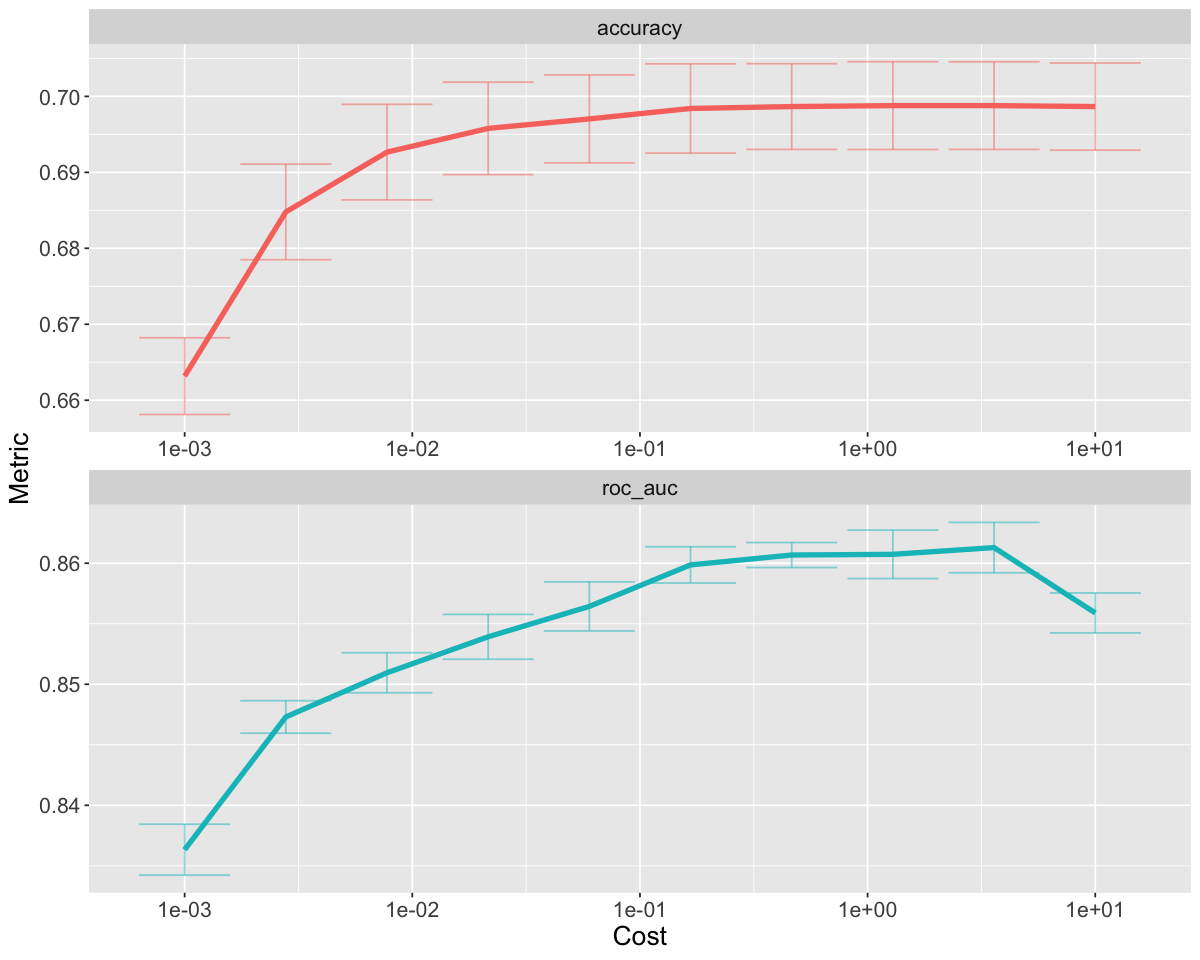

In [1056]:
fig(10,8)
svm_lin_fit %>%
    collect_metrics() %>%
    ggplot(aes(cost, mean, color = .metric)) +
    geom_errorbar(aes(ymin = mean - std_err,
                      ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Cost', y='Metric') +
    theme(legend.position = "none",
          text=element_text(size=16))

In [1057]:
svm_lin_best <- svm_lin_fit %>%
    #select_by_one_std_err(metric="accuracy", desc(cost_complexity))
    select_best(metric="roc_auc")
    #select_by_one_std_err(metric="rmse", penalty)

In [1064]:
svm_lin_best_fit <- svm_lin_wf %>% 
    finalize_workflow(svm_lin_best) %>%
    fit(data=songs_train)

#svm_lin_results <- svm_lin_best_fit %>%
#    predict(new_data = songs_test) %>%
#    bind_cols(songs_test, .) #%>%
    #select(pop.class, .pred_class)

maximum number of iterations reached 0.01320169 -0.0116003

In [1069]:
svm_lin_best_fit %>% 
    predict(new_data = songs_test)

ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `pop.class` doesn't exist.


In [1226]:
svm_lin_results %>%
    yardstick::accuracy(.pred_class, pop.class)

.metric  .estimator .estimate
1 accuracy multiclass 0.6783392

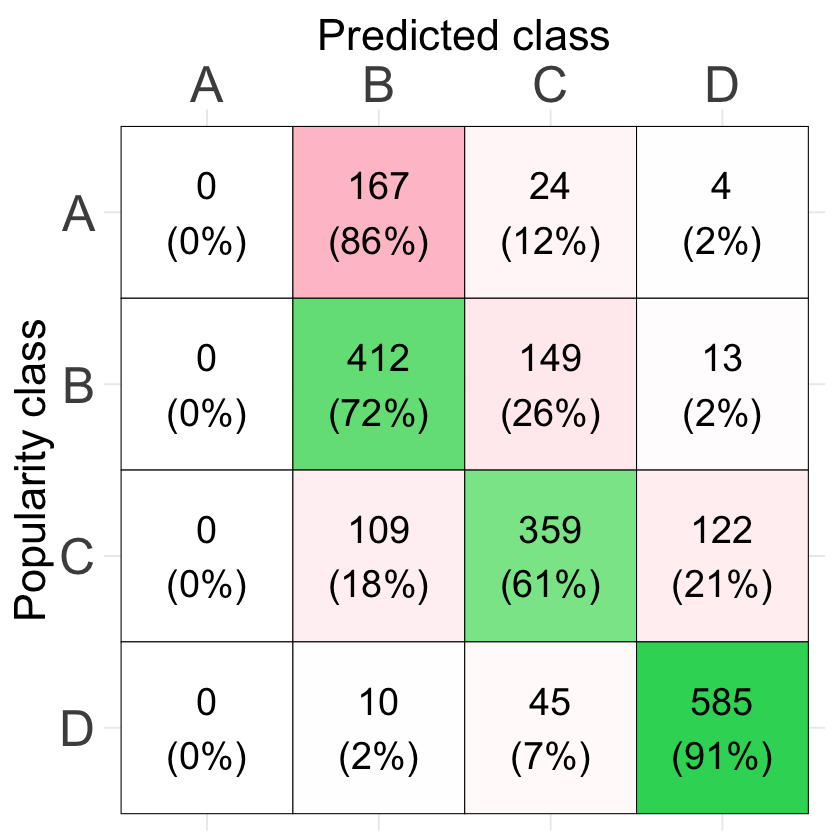

In [1227]:
plot_conf_mat(svm_lin_results)

In [821]:
songs_rec <-
    recipe(pop.class ~ ., data = songs_train) %>%
    step_normalize(all_numeric(), -all_outcomes())

In [822]:
formula_res <-
    svm_mod %>% 
    tune_grid(
        songs_rec,
        resamples = songs_cv,
        grid = tibble(cost=seq(.1, 2, length=2))
    )
#formula_res

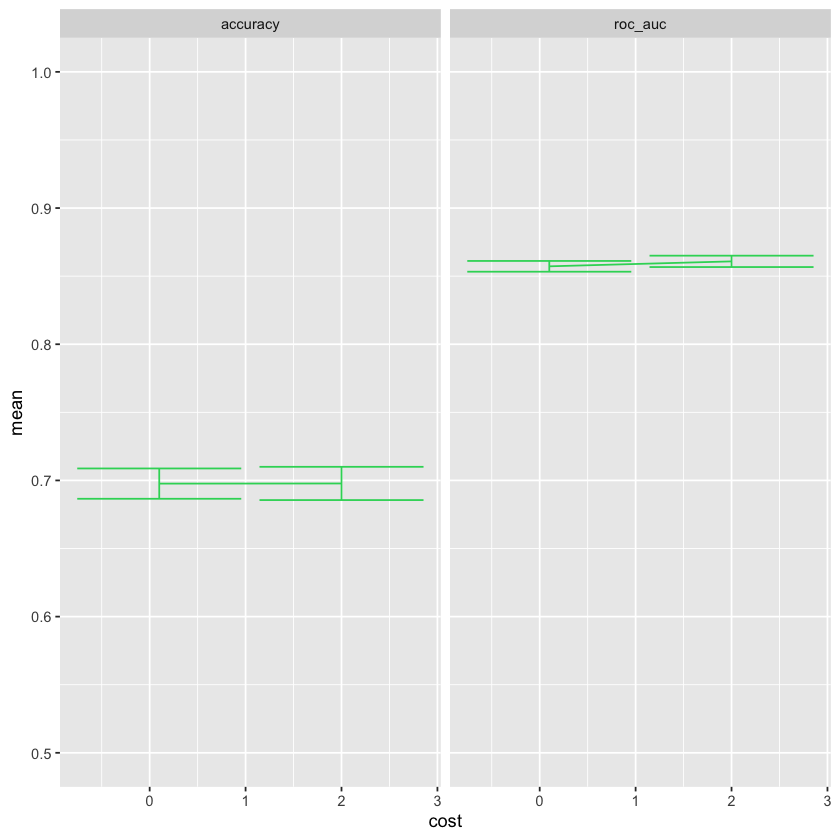

In [823]:
estimates <- collect_metrics(formula_res)
estimates %>%
    #filter(.metric=='roc_auc') %>%
    select(cost, mean, std_err, .metric) %>%
ggplot(aes(cost, mean)) + 
    #geom_smooth(aes(ymax=mean+2*std_err, ymin=mean-2*std_err), stat='identity', color='#2FD565') + 
    geom_line(color='#2FD565') +
    geom_errorbar(aes(ymax=mean+2*std_err, ymin=mean-2*std_err), color='#2FD565') +
    scale_y_continuous(limits=c(0.5,1)) +
    facet_wrap(~.metric)

In [76]:
formula_res %>%
    show_best() %>%
    slice(1) %>%
    select(cost, rbf_sigma)

Warning message:
“No value of `metric` was given; metric 'roc_auc' will be used.”


cost       rbf_sigma    .metric .estimator mean      n std_err   
1 0.28763358 9.762744e-02 roc_auc hand_till  0.8183642 3 0.05502339
2 0.01003550 1.696628e-01 roc_auc hand_till  0.8108025 3 0.05064833
3 0.04485304 1.345124e-03 roc_auc hand_till  0.7634259 3 0.07063941
4 0.62503907 4.405540e-10 roc_auc hand_till  0.7368827 3 0.01136645
5 7.12861535 1.312155e-05 roc_auc hand_till  0.7364198 3 0.04964821
  .config              
1 Preprocessor1_Model06
2 Preprocessor1_Model03
3 Preprocessor1_Model09
4 Preprocessor1_Model10
5 Preprocessor1_Model08

In [ ]:
svm_results <- 
  songs_test %>%
  select(pop.class) %>%
  bind_cols(
    predict(s_fit, new_data = songs_test %>% select(-pop.class))
  )

In [ ]:
svm_tidy <- svm_rbf(cost=params$cost, rbf_sigma=params$rbf_sigma) %>%
    set_mode('classification') %>%
    set_engine('kernlab')

In [ ]:
svm_tidy_fit <-
    svm_tidy %>%
    fit(pop.class ~ ., 
        data=songs_train)

#tidy(svm_tidy_fit) %>% filter(estimate > 0)

In [ ]:
svm_tidy_results <- 
  songs_test %>%
  select(pop.class) %>%
  bind_cols(
    predict(svm_tidy_fit, new_data = songs_test %>% select(-pop.class))
  )

In [ ]:
svm_tidy_results %>%
    conf_mat(truth=pop.class, estimate=.pred_class)

svm_tidy_results %>%
    yardstick::precision(pop.class, .pred_class)

### Polynomial kernel

In [1017]:
svm_poly_grid <- expand.grid(cost = 10^seq(-3,1, length.out = 5), degree = c(1:3))

svm_poly_rec <- recipe(pop.class ~ ., data = songs_train) %>%
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_dummy(all_nominal(), -all_outcomes())

svm_poly_mod <- svm_poly(degree= tune(), cost=tune()) %>%
    set_mode("classification") %>%
    set_engine("kernlab")

svm_poly_wf <- workflow() %>%
    add_recipe(svm_poly_rec) %>%
    add_model(svm_poly_mod)

In [1018]:
svm_poly_fit <- svm_poly_wf %>%
    tune_grid(
        resamples = songs_cv,
        grid = svm_poly_grid
    )

x Fold01: preprocessor 1/1, model 13/15 (predictions): Error: $ operator is invali...

x Fold01: preprocessor 1/1, model 14/15 (predictions): Error: $ operator is invali...

x Fold02: preprocessor 1/1, model 13/15 (predictions): Error: $ operator is invali...

Timing stopped at: 231.2 1.642 253.4



In [ ]:
svm_poly_fit %>%
    collect_metrics()

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



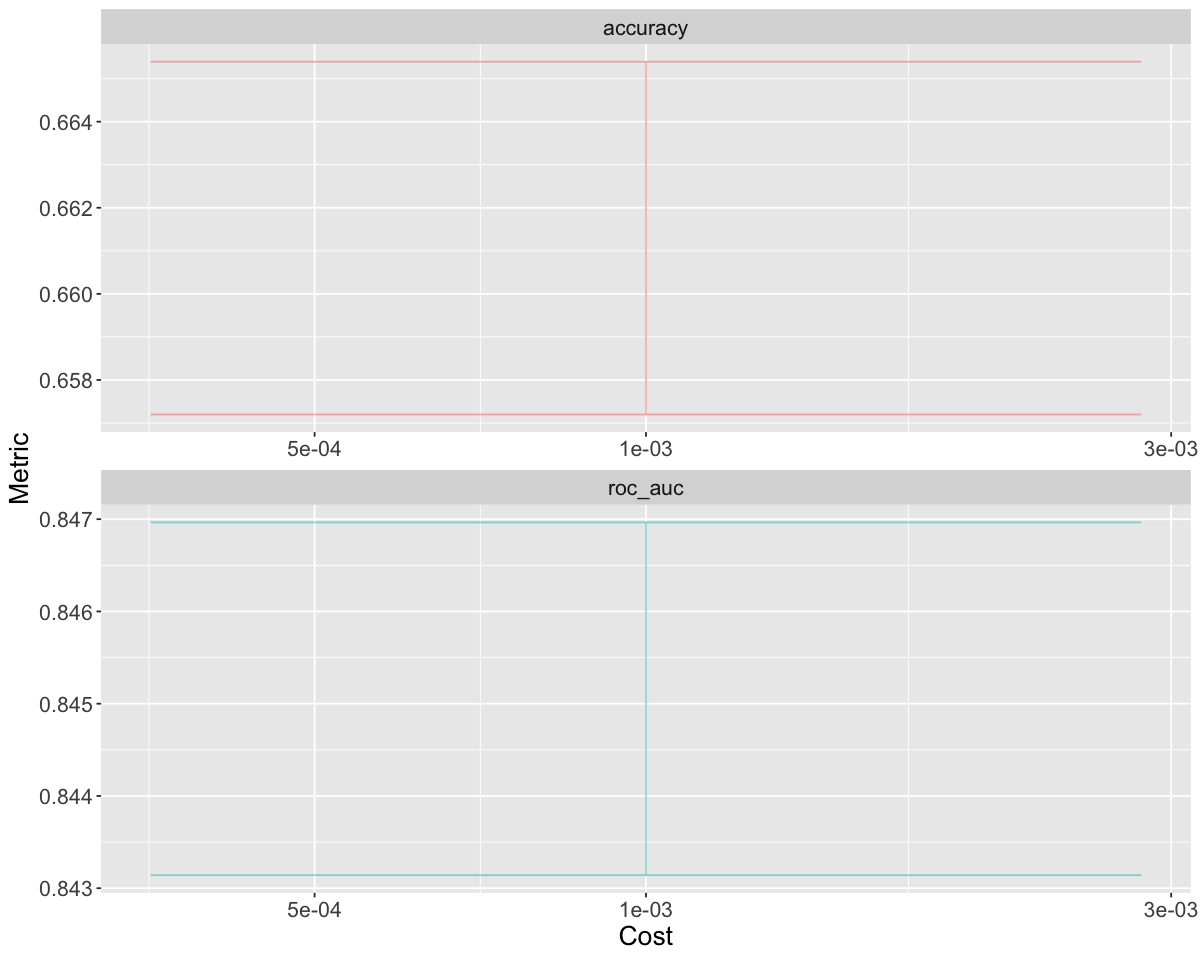

In [1011]:
fig(10,8)
svm_lin_fit %>%
    collect_metrics() %>%
    ggplot(aes(cost, mean, color = .metric)) +
    geom_errorbar(aes(ymin = mean - std_err,
                      ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Cost', y='Metric') +
    theme(legend.position = "none",
          text=element_text(size=16))

In [1012]:
svm_lin_best <- svm_lin_fit %>%
    #select_by_one_std_err(metric="accuracy", desc(cost_complexity))
    select_best(metric="roc_auc")
    #select_by_one_std_err(metric="rmse", penalty)

In [1014]:
svm_lin_best_fit <- svm_lin_wf %>% 
    finalize_workflow(svm_lin_best) %>%
    fit(data=songs_train)

svm_lin_results <- svm_lin_best_fit %>%
    predict(new_data = songs_test) %>%
    bind_cols(songs_test, .) %>%
    select(pop.class, .pred_class)

maximum number of iterations reached 0.009453395 -0.008562026

In [1228]:
svm_lin_results %>%
    yardstick::accuracy(.pred_class, pop.class)

.metric  .estimator .estimate
1 accuracy multiclass 0.6783392

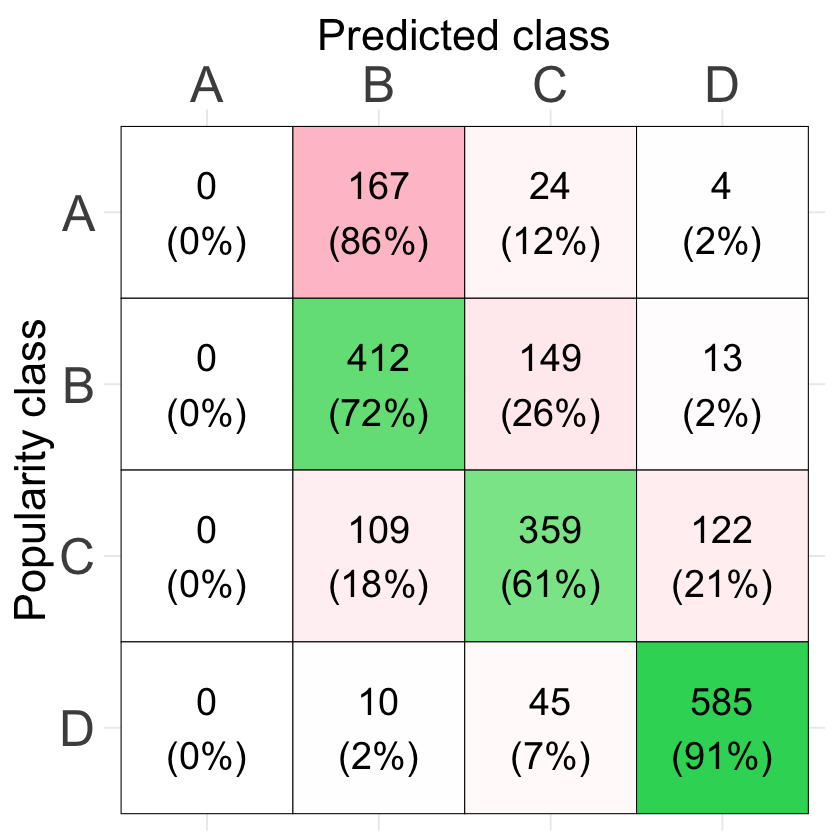

In [1229]:
plot_conf_mat(svm_lin_results)

### Radial kernel

In [570]:
svm_rad_grid <- tibble(cost = 10^seq(-4,1, length.out = 5))

svm_lin_rec <- recipe(pop.class ~ ., data = songs_train) %>%
    step_dummy(all_nominal(), -all_outcomes())

svm_lin_mod <- svm_poly(degree=1, cost=tune()) %>%
    set_mode("classification") %>%
    set_engine("kernlab")

svm_lin_wf <- workflow() %>%
    add_recipe(svm_lin_rec) %>%
    add_model(svm_lin_mod)

In [571]:
svm_lin_fit <- svm_lin_wf %>%
    tune_grid(
        resamples = songs_cv,
        grid = svm_lin_grid
    )

Timing stopped at: 16.41 0.396 19.94



In [572]:
svm_lin_fit %>%
    collect_metrics()

ERROR: Error in collect_metrics(.): object 'svm_lin_fit' not found


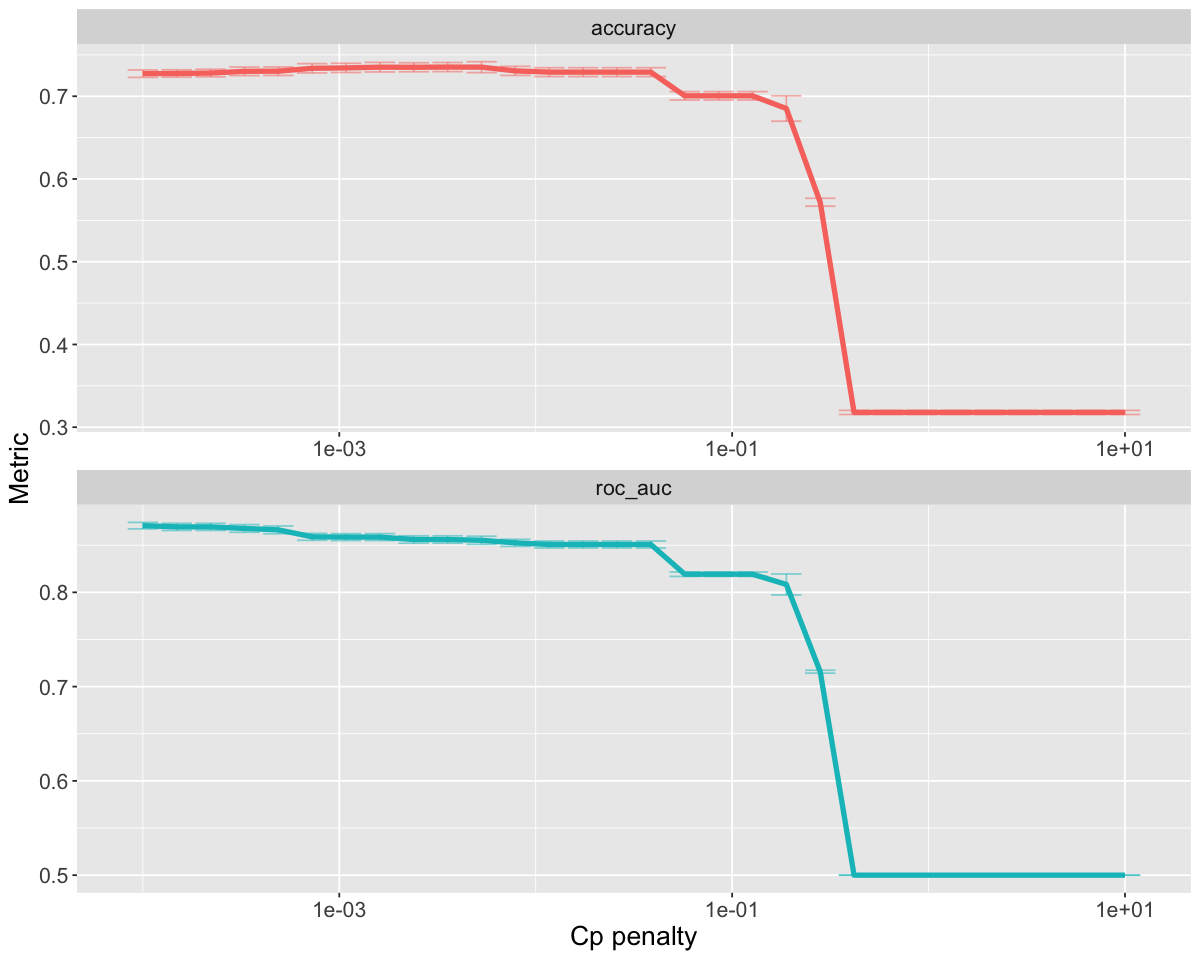

In [548]:
fig(10,8)
svm_lin_fit %>%
    collect_metrics() %>%
    ggplot(aes(cost, mean, color = .metric)) +
    geom_errorbar(aes(ymin = mean - std_err,
                      ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Cost', y='Metric') +
    theme(legend.position = "none",
          text=element_text(size=16))

In [550]:
tree_best <- tree_fit %>%
    select_by_one_std_err(metric="accuracy", desc(cost_complexity))
    #select_best(metric="accuracy")
    #select_by_one_std_err(metric="rmse", penalty)

In [454]:
library(xtable)
options(xtable.floating = FALSE)
options(xtable.timestamp = "")
lin_reg_wf %>% 
    finalize_workflow(lin_reg_best) %>%
    fit(songs_reg_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    filter(abs(estimate) > 0) %>%
    select(term, estimate) %>%
    xtable(type = "latex") %>%
print(file = "lm.tex")

In [558]:
tree_best_fit <- tree_wf %>% 
    finalize_workflow(tree_best) %>%
    fit(data=songs_train)

tree_results <- tree_best_fit %>%
    predict(new_data = songs_test) %>%
    bind_cols(songs_test, .) %>%
    select(pop.class, .pred_class)

In [569]:
tree_results %>%
    mutate(correct=pop.class == .pred_class) %>%
    summarise(accuracy=sum(correct==TRUE) / n)

accuracy 
1 0.7463732

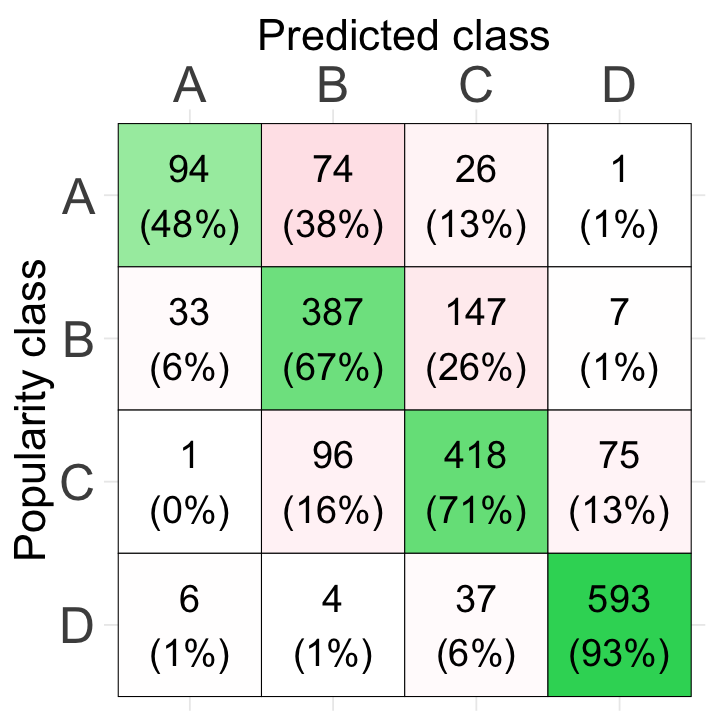

In [1238]:
plot_conf_mat(tree_results)

In [ ]:
rad_svm <- train(pop.class ~., 
                 data = songs_train, 
                 method = "svmRadial", 
                 trControl = train_control,  
                 preProcess = c("center","scale"),
                 tuneGrid = expand.grid(C = seq(.5, 2, length = 3), 
                                        sigma = seq(0.001, 0.2, length = 6)))

rad_svm

In [ ]:
plot(rad_svm)

In [ ]:
str(rad_svm$bestTune)

In [ ]:
rad_svm_mod <- svm_rbf(mode='classification', cost=rad_svm$bestTune$C, rbf_sigma=rad_svm$bestTune$sigma) %>%
    set_engine("kernlab")
rad_svm_mod

In [ ]:
rad_svm_fit <-
    rad_svm_mod %>%
    fit(pop.class ~ ., 
        data=songs_train)

tidy(rad_svm_fit)

In [ ]:
rad_svm_results <- 
  songs_test %>%
  select(pop.class) %>%
  bind_cols(
    predict(rad_svm_fit, new_data = songs_test %>% select(-pop.class))
  )
head(rad_svm_results)

In [ ]:
rad_svm_results %>%
    conf_mat(truth=pop.class, estimate=.pred_class)

rad_svm_results %>%
    yardstick::precision(truth=pop.class, estimate=.pred_class)

## Decision tree

In [1070]:
tree_grid <- tibble(cost_complexity = 10^seq(-3, 0, length.out = 30))

tree_rec <- recipe(pop.class ~ ., data = songs_train) #%>%
    #step_normalize(all_numeric(), -all_outcomes()) %>%
    #step_dummy(all_nominal(), -all_outcomes())

tree_mod <- decision_tree(cost_complexity = tune(), tree_depth=5) %>%
    set_mode("classification") %>%
    set_engine("rpart")

tree_wf <- workflow() %>%
    add_recipe(tree_rec) %>%
    add_model(tree_mod)

In [1071]:
tree_fit <- tree_wf %>%
    tune_grid(
        resamples = songs_cv,
        grid = tree_grid,
        control = control_grid(verbose=TRUE)
    )

i Fold01: preprocessor 1/1

✓ Fold01: preprocessor 1/1

i Fold01: preprocessor 1/1, model 1/30

✓ Fold01: preprocessor 1/1, model 1/30

i Fold01: preprocessor 1/1, model 1/30 (predictions)

i Fold01: preprocessor 1/1, model 2/30

✓ Fold01: preprocessor 1/1, model 2/30

i Fold01: preprocessor 1/1, model 2/30 (predictions)

i Fold01: preprocessor 1/1, model 3/30

✓ Fold01: preprocessor 1/1, model 3/30

i Fold01: preprocessor 1/1, model 3/30 (predictions)

i Fold01: preprocessor 1/1, model 4/30

✓ Fold01: preprocessor 1/1, model 4/30

i Fold01: preprocessor 1/1, model 4/30 (predictions)

i Fold01: preprocessor 1/1, model 5/30

✓ Fold01: preprocessor 1/1, model 5/30

i Fold01: preprocessor 1/1, model 5/30 (predictions)

i Fold01: preprocessor 1/1, model 6/30

✓ Fold01: preprocessor 1/1, model 6/30

i Fold01: preprocessor 1/1, model 6/30 (predictions)

i Fold01: preprocessor 1/1, model 7/30

✓ Fold01: preprocessor 1/1, model 7/30

i Fold01: preprocessor 1/1, model 7/30 (predictions)

i Fold

i Fold02: preprocessor 1/1, model 12/30

✓ Fold02: preprocessor 1/1, model 12/30

i Fold02: preprocessor 1/1, model 12/30 (predictions)

i Fold02: preprocessor 1/1, model 13/30

✓ Fold02: preprocessor 1/1, model 13/30

i Fold02: preprocessor 1/1, model 13/30 (predictions)

i Fold02: preprocessor 1/1, model 14/30

✓ Fold02: preprocessor 1/1, model 14/30

i Fold02: preprocessor 1/1, model 14/30 (predictions)

i Fold02: preprocessor 1/1, model 15/30

✓ Fold02: preprocessor 1/1, model 15/30

i Fold02: preprocessor 1/1, model 15/30 (predictions)

i Fold02: preprocessor 1/1, model 16/30

✓ Fold02: preprocessor 1/1, model 16/30

i Fold02: preprocessor 1/1, model 16/30 (predictions)

i Fold02: preprocessor 1/1, model 17/30

✓ Fold02: preprocessor 1/1, model 17/30

i Fold02: preprocessor 1/1, model 17/30 (predictions)

i Fold02: preprocessor 1/1, model 18/30

✓ Fold02: preprocessor 1/1, model 18/30

i Fold02: preprocessor 1/1, model 18/30 (predictions)

i Fold02: preprocessor 1/1, model 19/30



✓ Fold03: preprocessor 1/1, model 23/30

i Fold03: preprocessor 1/1, model 23/30 (predictions)

i Fold03: preprocessor 1/1, model 24/30

✓ Fold03: preprocessor 1/1, model 24/30

i Fold03: preprocessor 1/1, model 24/30 (predictions)

i Fold03: preprocessor 1/1, model 25/30

✓ Fold03: preprocessor 1/1, model 25/30

i Fold03: preprocessor 1/1, model 25/30 (predictions)

i Fold03: preprocessor 1/1, model 26/30

✓ Fold03: preprocessor 1/1, model 26/30

i Fold03: preprocessor 1/1, model 26/30 (predictions)

i Fold03: preprocessor 1/1, model 27/30

✓ Fold03: preprocessor 1/1, model 27/30

i Fold03: preprocessor 1/1, model 27/30 (predictions)

i Fold03: preprocessor 1/1, model 28/30

✓ Fold03: preprocessor 1/1, model 28/30

i Fold03: preprocessor 1/1, model 28/30 (predictions)

i Fold03: preprocessor 1/1, model 29/30

✓ Fold03: preprocessor 1/1, model 29/30

i Fold03: preprocessor 1/1, model 29/30 (predictions)

i Fold03: preprocessor 1/1, model 30/30

✓ Fold03: preprocessor 1/1, model 30/30



✓ Fold05: preprocessor 1/1, model 4/30

i Fold05: preprocessor 1/1, model 4/30 (predictions)

i Fold05: preprocessor 1/1, model 5/30

✓ Fold05: preprocessor 1/1, model 5/30

i Fold05: preprocessor 1/1, model 5/30 (predictions)

i Fold05: preprocessor 1/1, model 6/30

✓ Fold05: preprocessor 1/1, model 6/30

i Fold05: preprocessor 1/1, model 6/30 (predictions)

i Fold05: preprocessor 1/1, model 7/30

✓ Fold05: preprocessor 1/1, model 7/30

i Fold05: preprocessor 1/1, model 7/30 (predictions)

i Fold05: preprocessor 1/1, model 8/30

✓ Fold05: preprocessor 1/1, model 8/30

i Fold05: preprocessor 1/1, model 8/30 (predictions)

i Fold05: preprocessor 1/1, model 9/30

✓ Fold05: preprocessor 1/1, model 9/30

i Fold05: preprocessor 1/1, model 9/30 (predictions)

i Fold05: preprocessor 1/1, model 10/30

✓ Fold05: preprocessor 1/1, model 10/30

i Fold05: preprocessor 1/1, model 10/30 (predictions)

i Fold05: preprocessor 1/1, model 11/30

✓ Fold05: preprocessor 1/1, model 11/30

i Fold05: preproc

i Fold06: preprocessor 1/1, model 16/30

✓ Fold06: preprocessor 1/1, model 16/30

i Fold06: preprocessor 1/1, model 16/30 (predictions)

i Fold06: preprocessor 1/1, model 17/30

✓ Fold06: preprocessor 1/1, model 17/30

i Fold06: preprocessor 1/1, model 17/30 (predictions)

i Fold06: preprocessor 1/1, model 18/30

✓ Fold06: preprocessor 1/1, model 18/30

i Fold06: preprocessor 1/1, model 18/30 (predictions)

i Fold06: preprocessor 1/1, model 19/30

✓ Fold06: preprocessor 1/1, model 19/30

i Fold06: preprocessor 1/1, model 19/30 (predictions)

i Fold06: preprocessor 1/1, model 20/30

✓ Fold06: preprocessor 1/1, model 20/30

i Fold06: preprocessor 1/1, model 20/30 (predictions)

i Fold06: preprocessor 1/1, model 21/30

✓ Fold06: preprocessor 1/1, model 21/30

i Fold06: preprocessor 1/1, model 21/30 (predictions)

i Fold06: preprocessor 1/1, model 22/30

✓ Fold06: preprocessor 1/1, model 22/30

i Fold06: preprocessor 1/1, model 22/30 (predictions)

i Fold06: preprocessor 1/1, model 23/30



✓ Fold07: preprocessor 1/1, model 27/30

i Fold07: preprocessor 1/1, model 27/30 (predictions)

i Fold07: preprocessor 1/1, model 28/30

✓ Fold07: preprocessor 1/1, model 28/30

i Fold07: preprocessor 1/1, model 28/30 (predictions)

i Fold07: preprocessor 1/1, model 29/30

✓ Fold07: preprocessor 1/1, model 29/30

i Fold07: preprocessor 1/1, model 29/30 (predictions)

i Fold07: preprocessor 1/1, model 30/30

✓ Fold07: preprocessor 1/1, model 30/30

i Fold07: preprocessor 1/1, model 30/30 (predictions)

i Fold08: preprocessor 1/1

✓ Fold08: preprocessor 1/1

i Fold08: preprocessor 1/1, model 1/30

✓ Fold08: preprocessor 1/1, model 1/30

i Fold08: preprocessor 1/1, model 1/30 (predictions)

i Fold08: preprocessor 1/1, model 2/30

✓ Fold08: preprocessor 1/1, model 2/30

i Fold08: preprocessor 1/1, model 2/30 (predictions)

i Fold08: preprocessor 1/1, model 3/30

✓ Fold08: preprocessor 1/1, model 3/30

i Fold08: preprocessor 1/1, model 3/30 (predictions)

i Fold08: preprocessor 1/1, model 4

✓ Fold09: preprocessor 1/1, model 8/30

i Fold09: preprocessor 1/1, model 8/30 (predictions)

i Fold09: preprocessor 1/1, model 9/30

✓ Fold09: preprocessor 1/1, model 9/30

i Fold09: preprocessor 1/1, model 9/30 (predictions)

i Fold09: preprocessor 1/1, model 10/30

✓ Fold09: preprocessor 1/1, model 10/30

i Fold09: preprocessor 1/1, model 10/30 (predictions)

i Fold09: preprocessor 1/1, model 11/30

✓ Fold09: preprocessor 1/1, model 11/30

i Fold09: preprocessor 1/1, model 11/30 (predictions)

i Fold09: preprocessor 1/1, model 12/30

✓ Fold09: preprocessor 1/1, model 12/30

i Fold09: preprocessor 1/1, model 12/30 (predictions)

i Fold09: preprocessor 1/1, model 13/30

✓ Fold09: preprocessor 1/1, model 13/30

i Fold09: preprocessor 1/1, model 13/30 (predictions)

i Fold09: preprocessor 1/1, model 14/30

✓ Fold09: preprocessor 1/1, model 14/30

i Fold09: preprocessor 1/1, model 14/30 (predictions)

i Fold09: preprocessor 1/1, model 15/30

✓ Fold09: preprocessor 1/1, model 15/30

i Fol

i Fold10: preprocessor 1/1, model 19/30 (predictions)

i Fold10: preprocessor 1/1, model 20/30

✓ Fold10: preprocessor 1/1, model 20/30

i Fold10: preprocessor 1/1, model 20/30 (predictions)

i Fold10: preprocessor 1/1, model 21/30

✓ Fold10: preprocessor 1/1, model 21/30

i Fold10: preprocessor 1/1, model 21/30 (predictions)

i Fold10: preprocessor 1/1, model 22/30

✓ Fold10: preprocessor 1/1, model 22/30

i Fold10: preprocessor 1/1, model 22/30 (predictions)

i Fold10: preprocessor 1/1, model 23/30

✓ Fold10: preprocessor 1/1, model 23/30

i Fold10: preprocessor 1/1, model 23/30 (predictions)

i Fold10: preprocessor 1/1, model 24/30

✓ Fold10: preprocessor 1/1, model 24/30

i Fold10: preprocessor 1/1, model 24/30 (predictions)

i Fold10: preprocessor 1/1, model 25/30

✓ Fold10: preprocessor 1/1, model 25/30

i Fold10: preprocessor 1/1, model 25/30 (predictions)

i Fold10: preprocessor 1/1, model 26/30

✓ Fold10: preprocessor 1/1, model 26/30

i Fold10: preprocessor 1/1, model 26/30 (

In [544]:
tree_fit %>%
    collect_metrics()

cost_complexity .metric  .estimator mean      n  std_err    
1   0.000100000    accuracy multiclass 0.7272834 10 0.004487460
2   0.000100000    roc_auc  hand_till  0.8707734 10 0.003429079
3   0.001778279    accuracy multiclass 0.7350328 10 0.005811134
4   0.001778279    roc_auc  hand_till  0.8585856 10 0.003667917
5   0.031622777    accuracy multiclass 0.7291578 10 0.005358137
6   0.031622777    roc_auc  hand_till  0.8507562 10 0.003691050
7   0.562341325    accuracy multiclass 0.3178340 10 0.002480773
8   0.562341325    roc_auc  hand_till  0.5000000 10 0.000000000
9  10.000000000    accuracy multiclass 0.3178340 10 0.002480773
10 10.000000000    roc_auc  hand_till  0.5000000 10 0.000000000
   .config             
1  Preprocessor1_Model1
2  Preprocessor1_Model1
3  Preprocessor1_Model2
4  Preprocessor1_Model2
5  Preprocessor1_Model3
6  Preprocessor1_Model3
7  Preprocessor1_Model4
8  Preprocessor1_Model4
9  Preprocessor1_Model5
10 Preprocessor1_Model5

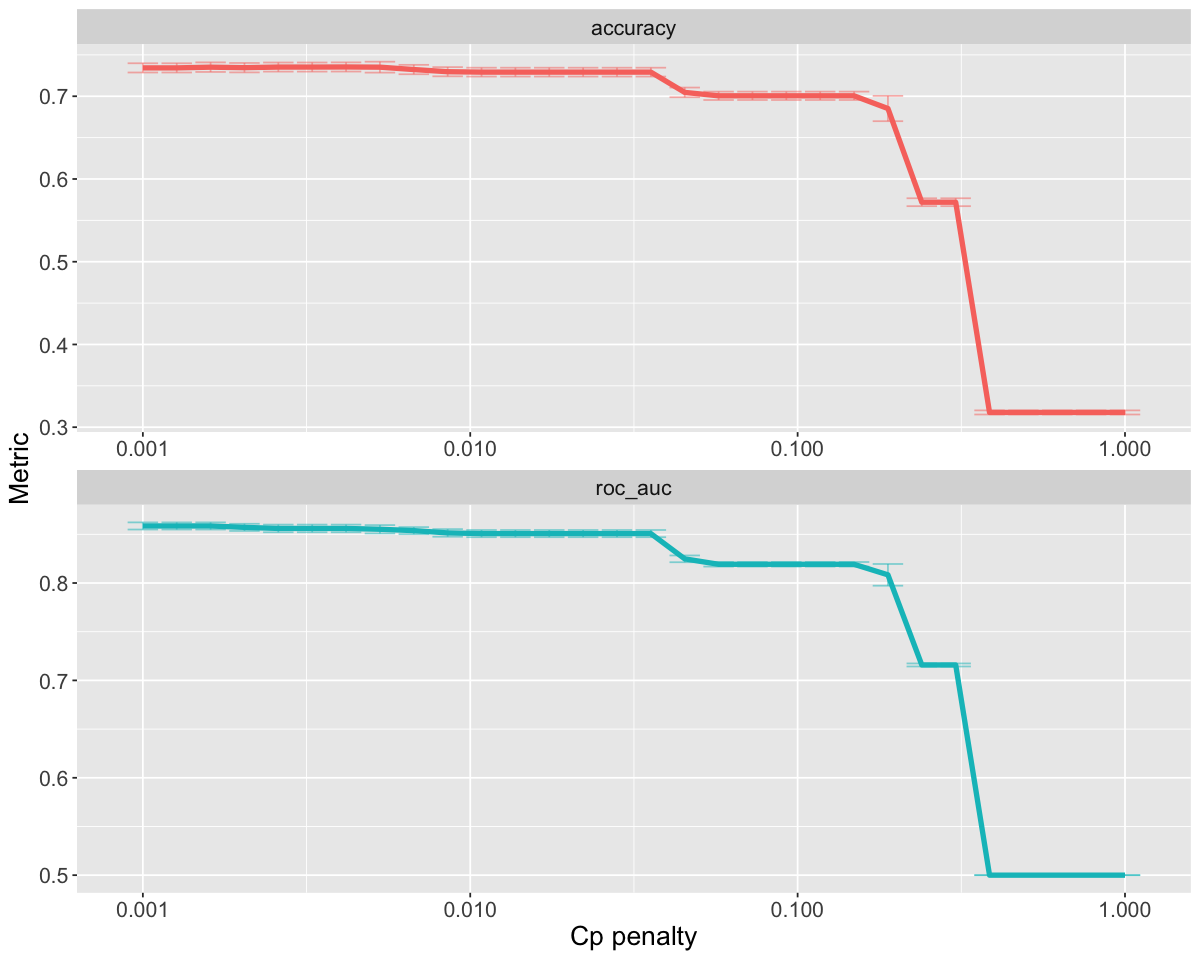

In [1082]:
fig(10,8)
tree_fit %>%
    collect_metrics() %>%
    ggplot(aes(cost_complexity, mean, color = .metric)) +
    geom_errorbar(aes(ymin = mean - std_err,
                      ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Cp penalty', y='Metric') +
    theme(legend.position = "none",
          text=element_text(size=16))

In [1187]:
tree_best <- tree_fit %>%
    #collect_metrics() %>%
    #arrange(.metric, desc(mean), cost_complexity) %>%
    #slice(16)
    select_by_one_std_err(metric="accuracy", desc(cost_complexity))
    #select_best(metric="accuracy")
    #select_by_one_std_err(metric="rmse", penalty)
#tree_best
#tree_fit %>%
#    collect_metrics() %>%
#    arrange(.metric, desc(mean), cost_complexity) %>% mutate(row=row_number())

In [1188]:
tree_best

cost_complexity .metric  .estimator mean      n  std_err    
1 0.006723358     accuracy multiclass 0.7322828 10 0.005679312
  .config               .best     .bound   
1 Preprocessor1_Model09 0.7354078 0.7298596

In [1190]:
tree_best_fit <- tree_wf %>% 
    finalize_workflow(tree_best) %>%
    fit(data=songs_train)

tree_results <- tree_best_fit %>%
    predict(new_data = songs_test) %>%
    bind_cols(songs_test, .) %>%
    select(pop.class, .pred_class)

In [1235]:
tree_results %>%
    accuracy(pop.class, .pred_class)

.metric  .estimator .estimate
1 accuracy multiclass 0.7463732

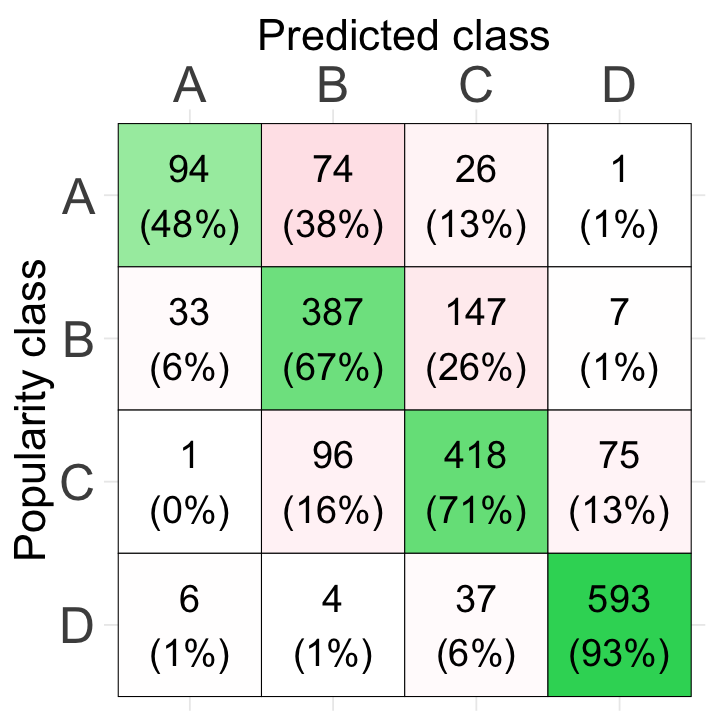

In [1236]:
plot_conf_mat(tree_results)

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


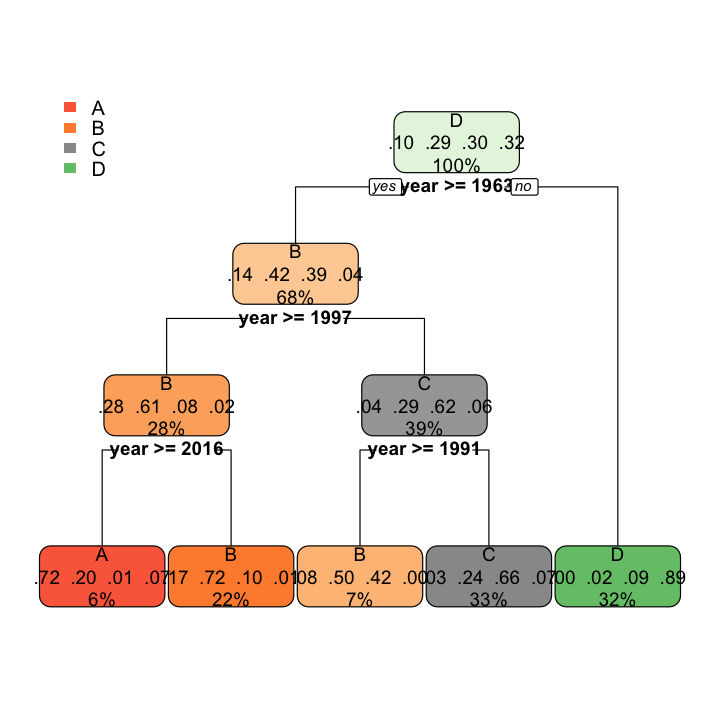

In [1237]:
library(rpart.plot)
rpart.plot(tree_best_fit$fit$fit$fit)

In [748]:
library(keras)


Attaching package: ‘keras’


The following object is masked from ‘package:yardstick’:

    get_weights




In [1088]:
nn_grid <- tibble(epochs=c(30, 50, 100))

nn_rec <- recipe(pop.class ~ ., data = songs_train) %>%
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_dummy(all_nominal(), -all_outcomes())

nn_mod <- mlp(hidden_units = 8, epochs = tune()) %>%
    set_mode("classification") %>%
    set_engine("keras")

nn_wf <- workflow() %>%
    add_recipe(nn_rec) %>%
    add_model(nn_mod)

In [1090]:
nn_fit <- nn_wf %>%
    tune_grid(
        resamples = songs_cv,
        grid = nn_grid,
        control = control_grid(verbose=TRUE)
    )

i Fold01: preprocessor 1/1

✓ Fold01: preprocessor 1/1

i Fold01: preprocessor 1/1, model 1/3

✓ Fold01: preprocessor 1/1, model 1/3

i Fold01: preprocessor 1/1, model 1/3 (predictions)

i Fold01: preprocessor 1/1, model 2/3

✓ Fold01: preprocessor 1/1, model 2/3

i Fold01: preprocessor 1/1, model 2/3 (predictions)

i Fold01: preprocessor 1/1, model 3/3

✓ Fold01: preprocessor 1/1, model 3/3

i Fold01: preprocessor 1/1, model 3/3 (predictions)

i Fold02: preprocessor 1/1

✓ Fold02: preprocessor 1/1

i Fold02: preprocessor 1/1, model 1/3

✓ Fold02: preprocessor 1/1, model 1/3

i Fold02: preprocessor 1/1, model 1/3 (predictions)

i Fold02: preprocessor 1/1, model 2/3

✓ Fold02: preprocessor 1/1, model 2/3

i Fold02: preprocessor 1/1, model 2/3 (predictions)

i Fold02: preprocessor 1/1, model 3/3

✓ Fold02: preprocessor 1/1, model 3/3

i Fold02: preprocessor 1/1, model 3/3 (predictions)

i Fold03: preprocessor 1/1

✓ Fold03: preprocessor 1/1

i Fold03: preprocessor 1/1, model 1/3

✓ Fold0

In [1091]:
nn_fit %>%
    collect_metrics()

epochs .metric  .estimator mean      n  std_err     .config             
1  30    accuracy multiclass 0.7001620 10 0.006211960 Preprocessor1_Model1
2  30    roc_auc  hand_till  0.8726132 10 0.001990241 Preprocessor1_Model1
3  50    accuracy multiclass 0.7181589 10 0.005864754 Preprocessor1_Model2
4  50    roc_auc  hand_till  0.8773662 10 0.002106272 Preprocessor1_Model2
5 100    accuracy multiclass 0.7281587 10 0.006128506 Preprocessor1_Model3
6 100    roc_auc  hand_till  0.8819451 10 0.002623147 Preprocessor1_Model3

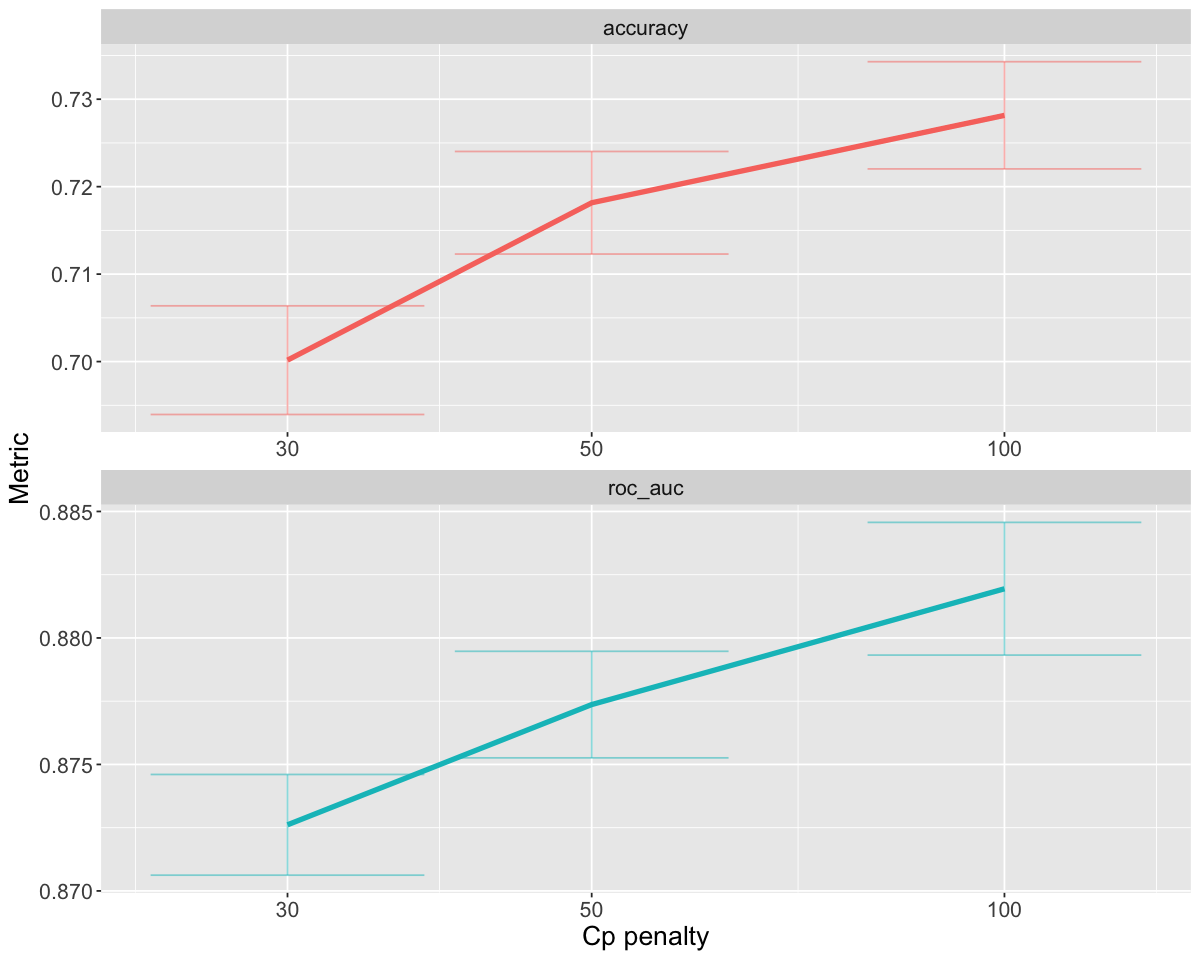

In [1092]:
fig(10,8)
nn_fit %>%
    collect_metrics() %>%
    ggplot(aes(epochs, mean, color = .metric)) +
    geom_errorbar(aes(ymin = mean - std_err,
                      ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Cp penalty', y='Metric') +
    theme(legend.position = "none",
          text=element_text(size=16))

In [1093]:
nn_best <- nn_fit %>%
    select_best(metric="accuracy")
    #select_by_one_std_err(metric="rmse", penalty)

In [1095]:
nn_best_fit <- nn_wf %>% 
    finalize_workflow(nn_best) %>%
    fit(data=songs_train)

nn_results <- nn_best_fit %>%
    predict(new_data = songs_test) %>%
    bind_cols(songs_test, .) %>%
    select(pop.class, .pred_class)

In [1230]:
nn_results %>%
    yardstick::accuracy(.pred_class, pop.class)

.metric  .estimator .estimate
1 accuracy multiclass 0.7398699

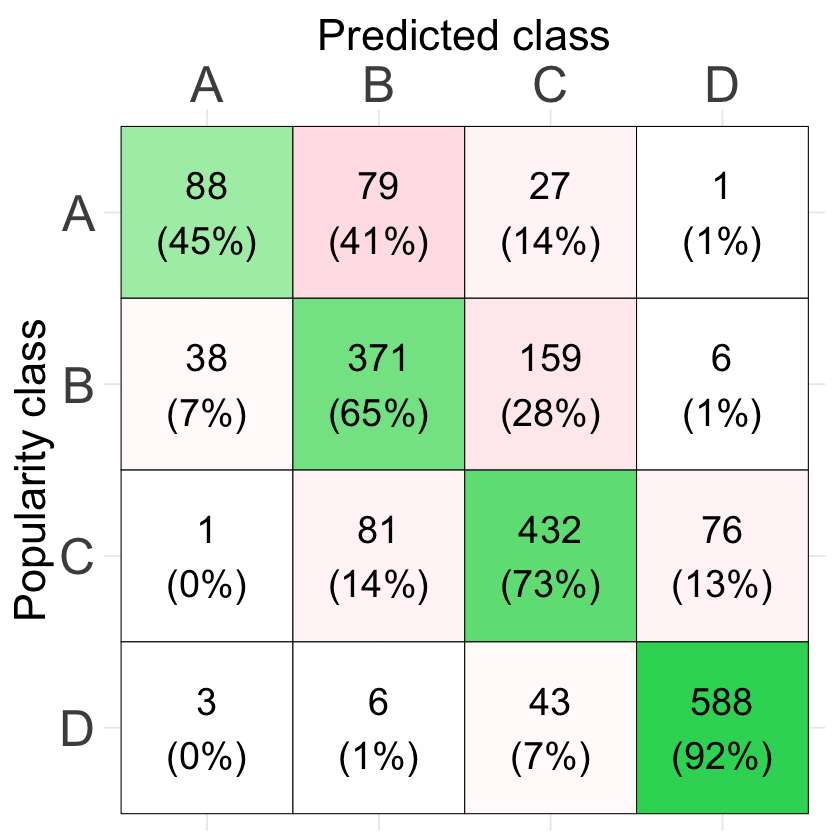

In [1231]:
plot_conf_mat(nn_results)

In [1109]:
nn_mod <- mlp(hidden_units = 16, epochs=300) %>%
    set_mode("classification") %>%
    set_engine("keras", verbose=2)

nn_wf <- workflow() %>%
    add_recipe(nn_rec) %>%
    add_model(nn_mod)

In [1110]:
nn_mod_fit <- nn_wf %>%
    fit(data=songs_train)

In [1111]:
nn_mod_results <- nn_mod_fit %>%
    predict(new_data = songs_test) %>%
    bind_cols(songs_test, .) %>%
    select(pop.class, .pred_class)

.metric  .estimator .estimate
1 accuracy multiclass 0.7318659

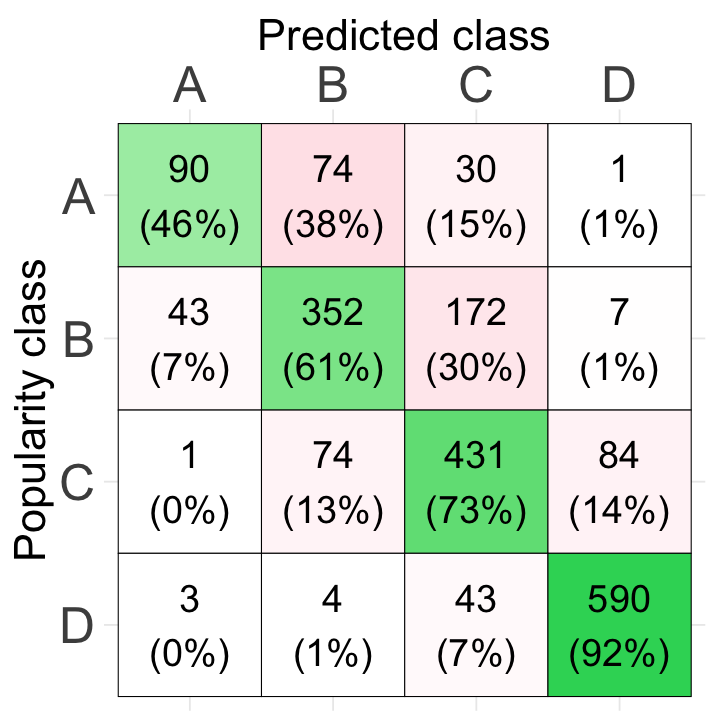

In [1244]:
nn_mod_results %>%
    yardstick::accuracy(pop.class, .pred_class)

fig(6,6)
plot_conf_mat(nn_mod_results)

# Regression models

#### With year

In [448]:
train_ratio <- .8
reg_data_split <- songs %>%
    initial_split(prop = train_ratio)

songs_reg_train <- training(reg_data_split) %>% 
    #select(!c(pop.class, year, key, mode, name)) %>% 
    #select(!c(pop.class, year, name)) %>% 
    select(!c(pop.class, name))
songs_reg_test  <- testing(reg_data_split)  %>% 
    #select(!c(pop.class, year, key, mode, name)) %>% 
    #select(!c(pop.class, year, name)) %>% 
    select(!c(pop.class, name))

In [449]:
songs_reg_cv <- rsample::vfold_cv(songs_reg_train, v=10, repeats=1)

In [1207]:
threshold_pred <- function(results) {
    results %>%
        mutate(D=ifelse(.pred<20, TRUE, FALSE)) %>%
        mutate(C=ifelse(.pred<40 & .pred>=20, TRUE, FALSE)) %>%
        mutate(B=ifelse(.pred<60 & .pred>=40, TRUE, FALSE)) %>%
        mutate(A=ifelse(.pred>=60, TRUE, FALSE)) %>%
        pivot_longer(cols=D:A, names_to = '.pred_class', values_to='dummy') %>%
        mutate(.pred_class=factor(.pred_class, levels=c('A', 'B', 'C', 'D'))) %>%
        filter(dummy) %>%
        select(!dummy)
}

In [1269]:
#lin_reg_grid <- tibble(penalty = 10^seq(-2,1, length.out = 30))
lin_reg_grid <- expand.grid(penalty = 10^seq(-1, 1, length.out = 20), mixture=seq(0,1, length = 3))

lin_reg_rec <- recipe(popularity ~ ., data = songs_reg_train) %>%
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_dummy(all_nominal(), -all_outcomes())

lin_reg_mod <- linear_reg(penalty = tune(), mixture = tune()) %>%
    set_engine("glmnet")

lin_reg_wf <- workflow() %>%
    add_recipe(lin_reg_rec) %>%
    add_model(lin_reg_mod) #%>% add_formula(popularity ~ .) 

In [1270]:
lin_reg_fit <- lin_reg_wf %>%
    tune_grid(
        resamples = songs_reg_cv,
        grid = lin_reg_grid,
        control = control_grid(verbose=TRUE)
    )

i Fold01: preprocessor 1/1

✓ Fold01: preprocessor 1/1

i Fold01: preprocessor 1/1, model 1/3

✓ Fold01: preprocessor 1/1, model 1/3

i Fold01: preprocessor 1/1, model 1/3 (predictions)

i Fold01: preprocessor 1/1, model 2/3

✓ Fold01: preprocessor 1/1, model 2/3

i Fold01: preprocessor 1/1, model 2/3 (predictions)

i Fold01: preprocessor 1/1, model 3/3

✓ Fold01: preprocessor 1/1, model 3/3

i Fold01: preprocessor 1/1, model 3/3 (predictions)

i Fold02: preprocessor 1/1

✓ Fold02: preprocessor 1/1

i Fold02: preprocessor 1/1, model 1/3

✓ Fold02: preprocessor 1/1, model 1/3

i Fold02: preprocessor 1/1, model 1/3 (predictions)

i Fold02: preprocessor 1/1, model 2/3

✓ Fold02: preprocessor 1/1, model 2/3

i Fold02: preprocessor 1/1, model 2/3 (predictions)

i Fold02: preprocessor 1/1, model 3/3

✓ Fold02: preprocessor 1/1, model 3/3

i Fold02: preprocessor 1/1, model 3/3 (predictions)

i Fold03: preprocessor 1/1

✓ Fold03: preprocessor 1/1

i Fold03: preprocessor 1/1, model 1/3

✓ Fold0

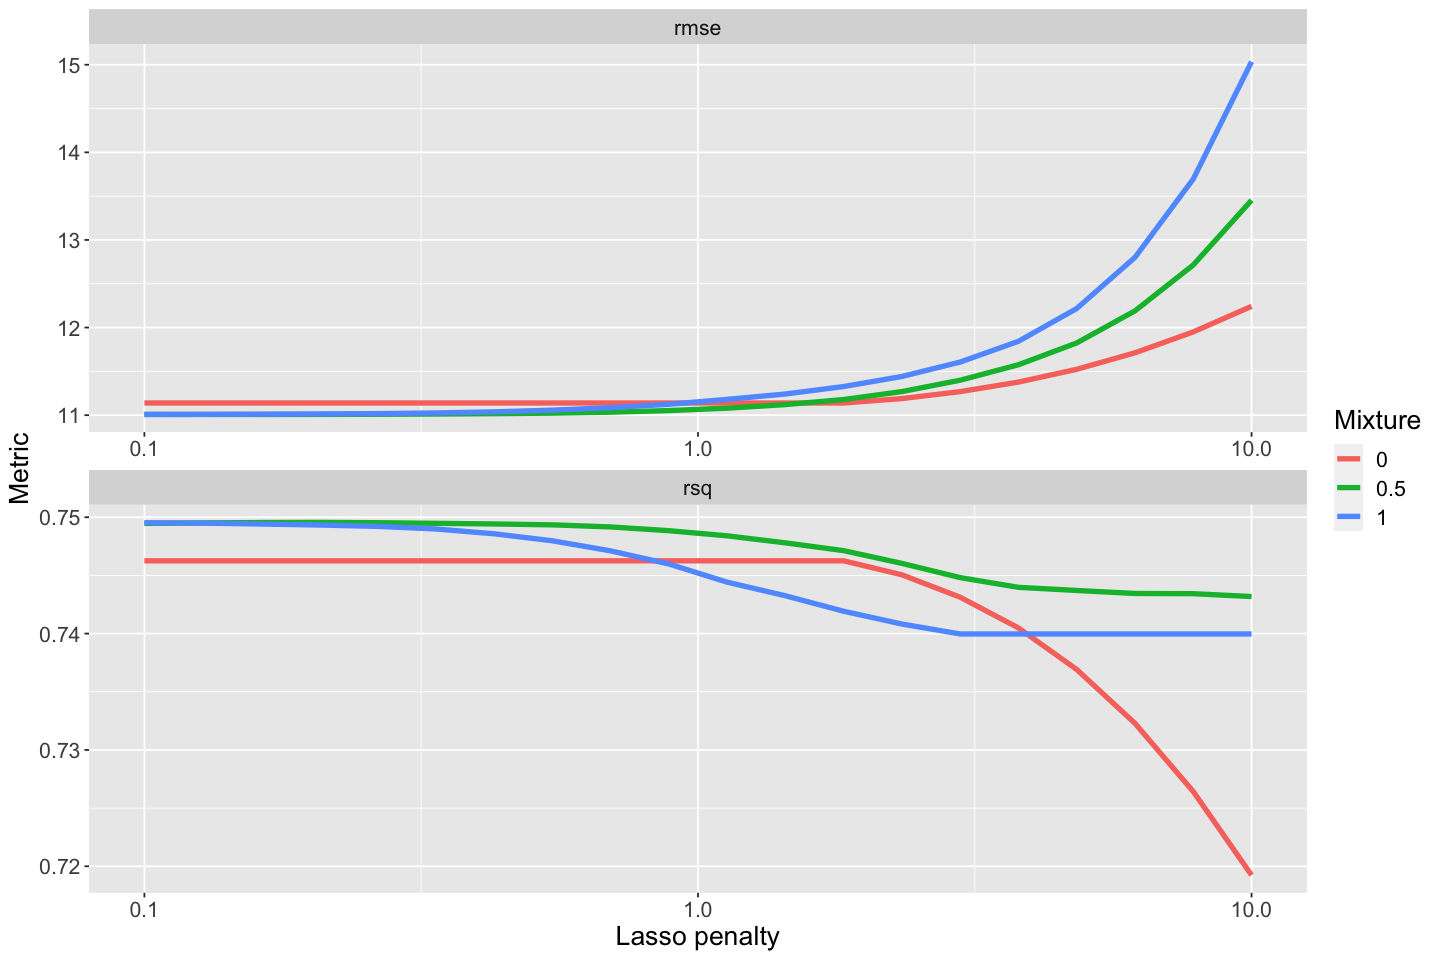

In [1276]:
fig(12,8)
lin_reg_fit %>%
    collect_metrics() %>%
    ggplot(aes(penalty, mean, color = factor(mixture))) +
    #geom_errorbar(aes(ymin = mean - std_err,
    #                  ymax = mean + std_err), alpha = 0.5) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    scale_x_log10() +
    labs(x='Lasso penalty', y='Metric', color='Mixture') +
    theme(text=element_text(size=16))

In [1277]:
lin_reg_fit %>%
    select_by_one_std_err(metric="rmse", desc(penalty))
    #select_by_one_std_err(metric="rmse", penalty)

penalty  mixture .metric .estimator mean     n  std_err  
1 1.832981 0       rmse    standard   11.13913 10 0.1572947
  .config               .best    .bound  
1 Preprocessor1_Model13 11.00782 11.18402

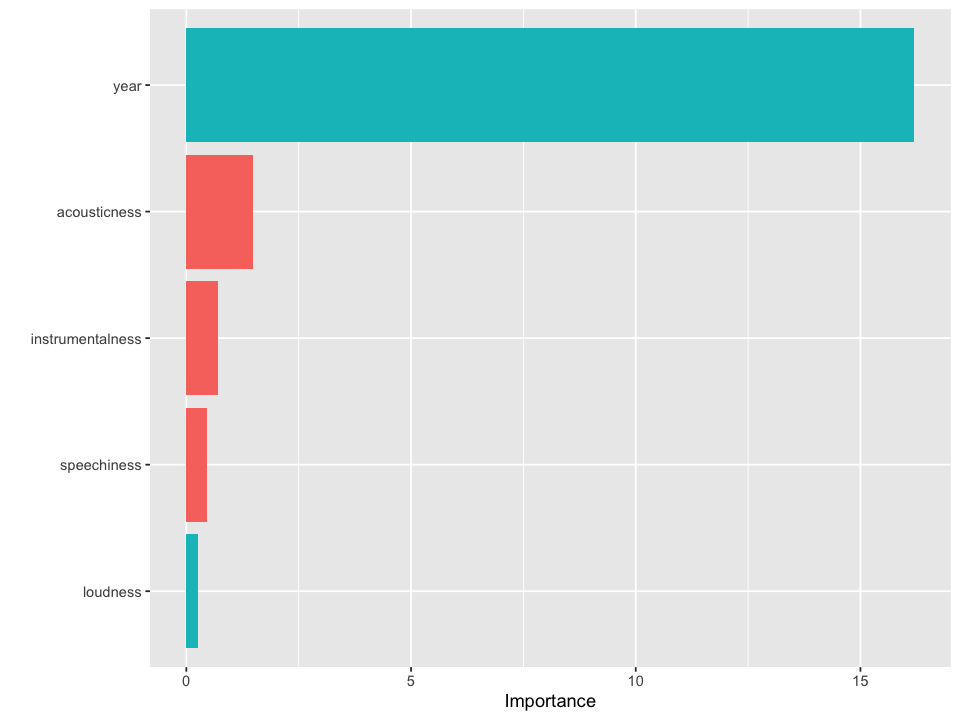

In [1263]:
lin_reg_best <- lin_reg_fit %>%
    select_by_one_std_err(metric="rmse", desc(penalty), desc(mixture))
    #select_by_one_std_err(metric="rmse", desc(penalty))
    #select_best(metric="rmse")

var_importance <- lin_reg_wf %>% 
    finalize_workflow(lin_reg_best) %>%
    fit(songs_reg_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    slice(-1) %>%
    filter(abs(estimate) > 0) %>%
    select(term, estimate) %>%
    mutate(abs_estimate=abs(estimate), sign=estimate>0) %>%
    arrange(desc(abs_estimate))

fig(8,6)
ggplot(var_importance) +
    geom_bar(stat='identity', aes(reorder(term, abs_estimate), abs_estimate, fill=sign)) +
    scale_x_discrete(breaks=var_importance$term) +
    labs(x='', y='Importance') +
    coord_flip() +
    guides(fill='none') 

In [1278]:
library(xtable)
options(xtable.floating = FALSE)
options(xtable.timestamp = "")
lin_reg_wf %>% 
    finalize_workflow(lin_reg_best) %>%
    fit(songs_reg_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    filter(abs(estimate) > 0) %>%
    select(term, estimate) %>%
    xtable(type = "latex") %>%
print(file = "lm.tex")

In [1281]:
lin_reg_best_fit <- lin_reg_wf %>% 
    finalize_workflow(lin_reg_best) %>%
    fit(data=songs_reg_train)


lin_reg_results <- lin_reg_best_fit %>%
    #predict(new_data = songs_reg_test) %>%
    predict(new_data = songs_reg_test) %>%
    bind_cols(testing(reg_data_split), .) %>%
    threshold_pred()

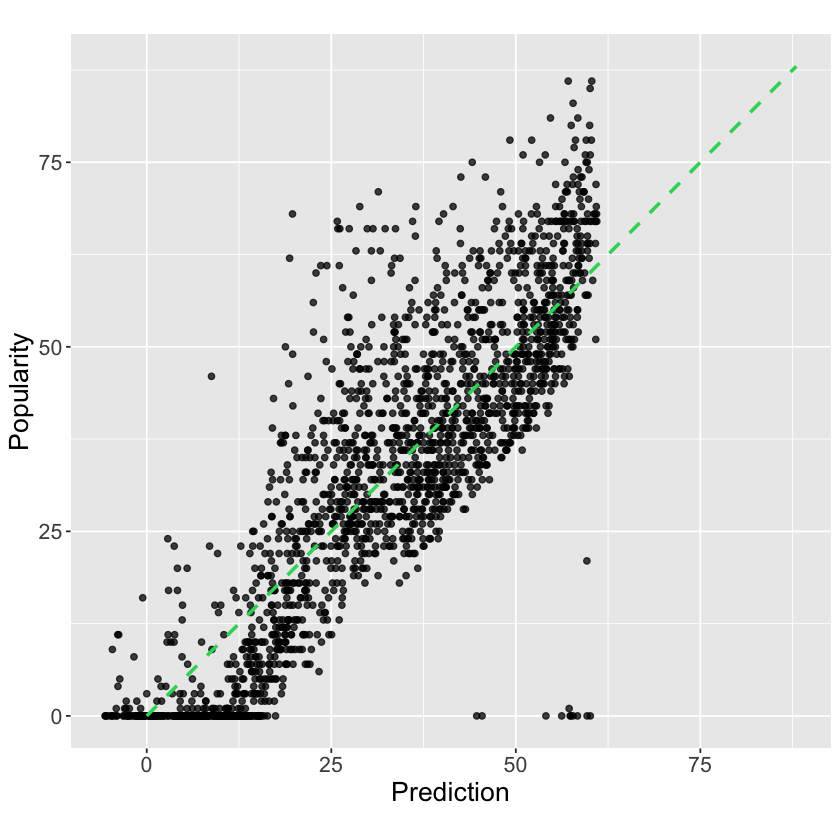

In [1291]:
max_pop <- 88
fig(7,7)
lin_reg_results %>%
    #mutate(.pred=pmax(pmin(.pred, 100), 0)) %>%
    ggplot(aes(.pred, popularity)) + 
    geom_point(alpha=.75) +
    annotate('line', x = c(0, max_pop), y = c(0, max_pop), color='#2FD565', size=1, linetype='dashed') +
    #scale_x_continuous(limits=c(0,100), name='Predicted popularity') +
    #scale_y_continuous(limits=c(0,100), name='Popularity') +
    labs(x='Prediction', y='Popularity') +
    theme(text=element_text(size=16)) +
    coord_equal()

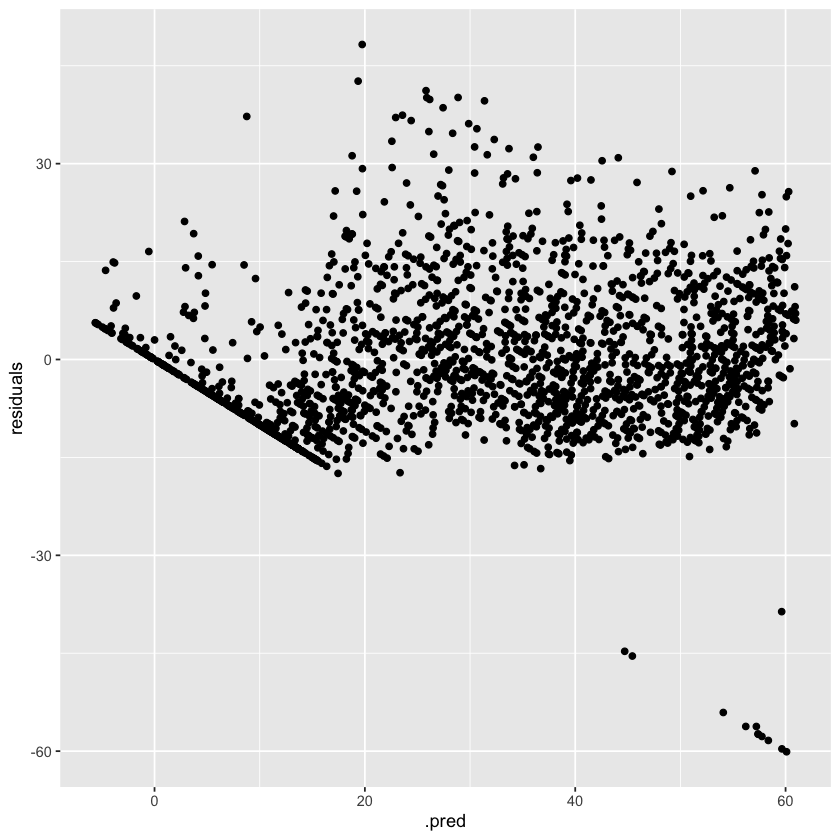

In [1288]:
lin_reg_results %>%
    mutate(residuals = popularity - .pred) %>%
ggplot(aes(.pred, residuals)) +
    geom_point()

### First try

In [298]:
lowest_rmse <- lasso_grid %>%
    select_by_one_std_err(metric="rmse", penalty)
    #select_best("rmse")

final_lasso <- finalize_workflow(
  wf %>% add_model(tune_spec),
  lowest_rmse
)

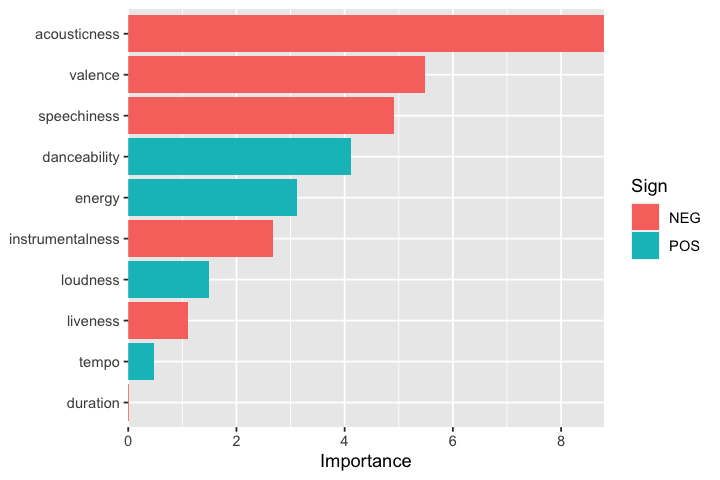

In [300]:
library(vip)

fig(6,4)
final_lasso %>%
  fit(songs_reg_train) %>%
  pull_workflow_fit() %>%
  vi(lambda = lowest_rmse$penalty) %>%
  mutate(
    Importance = abs(Importance),
    Variable = fct_reorder(Variable, Importance)
  ) %>%
  ggplot(aes(x = Importance, y = Variable, fill = Sign)) +
  geom_col() +
  scale_x_continuous(expand = c(0, 0)) +
  labs(y = NULL)

In [306]:
lin_reg_fit <- last_fit(
    final_lasso,
    reg_data_split
) %>%
    pull_workflow_fit() %>% str()

ERROR: Error: `x` must be a workflow, not a last_fit.


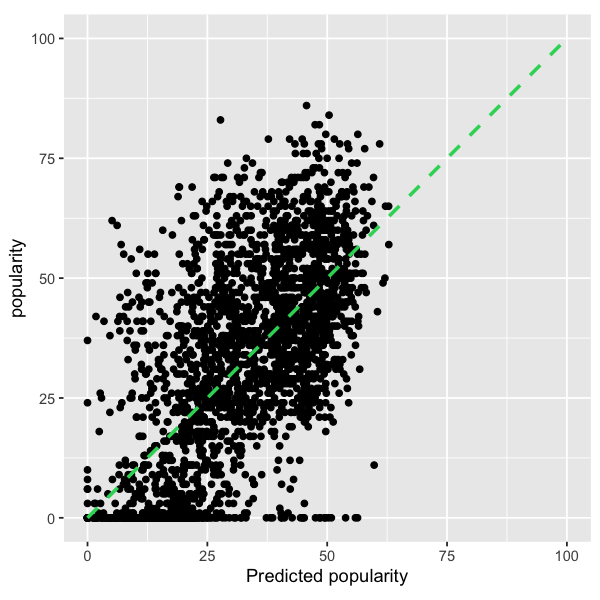

In [302]:
fig(5,5)
lin_reg_fit$.predictions[[1]] %>%
    mutate(.pred=pmax(pmin(.pred, 100), 0)) %>%
    ggplot(aes(.pred, popularity)) + 
    geom_point() +
    annotate('line', x = c(0,100), y = c(0,100), color='#2FD565', size=1, linetype='dashed') +
    scale_x_continuous(limits=c(0,100), name='Predicted popularity') +
    scale_y_continuous(limits=c(0,100)) +
    coord_equal()

## Linear SVM

In [469]:
lin_svm_reg_grid <- tibble(C = 10^seq(-4,1, length.out = 5))

lin_svm_reg_rec <- recipe(popularity ~ ., data = songs_reg_train) %>%
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_dummy(all_nominal(), -all_outcomes())

svm_reg_mod <- svm_polynomial(C = tune()) %>%
    set_mode("regression") %>%
    set_engine("kernlab")

lin_svm_reg_wf <- workflow() %>%
    add_recipe(lin_svm_reg_rec) %>%
    add_model(lin_svm_reg_mod)

ERROR: Error in svm_linear(C = tune()): could not find function "svm_linear"


## Decision tree regression

In [586]:
tree_reg_grid <- tibble(cost_complexity = seq(1e-4, 1e-2, length.out = 30))

tree_reg_rec <- recipe(popularity ~ ., data = songs_reg_train)

tree_reg_mod <- decision_tree(cost_complexity = tune()) %>%
    set_mode("regression") %>%
    set_engine("rpart")

tree_reg_wf <- workflow() %>%
    add_recipe(tree_reg_rec) %>%
    add_model(tree_reg_mod)

In [587]:
tree_reg_fit <- tree_reg_wf %>%
    tune_grid(
        resamples = songs_reg_cv,
        grid = tree_reg_grid
    )

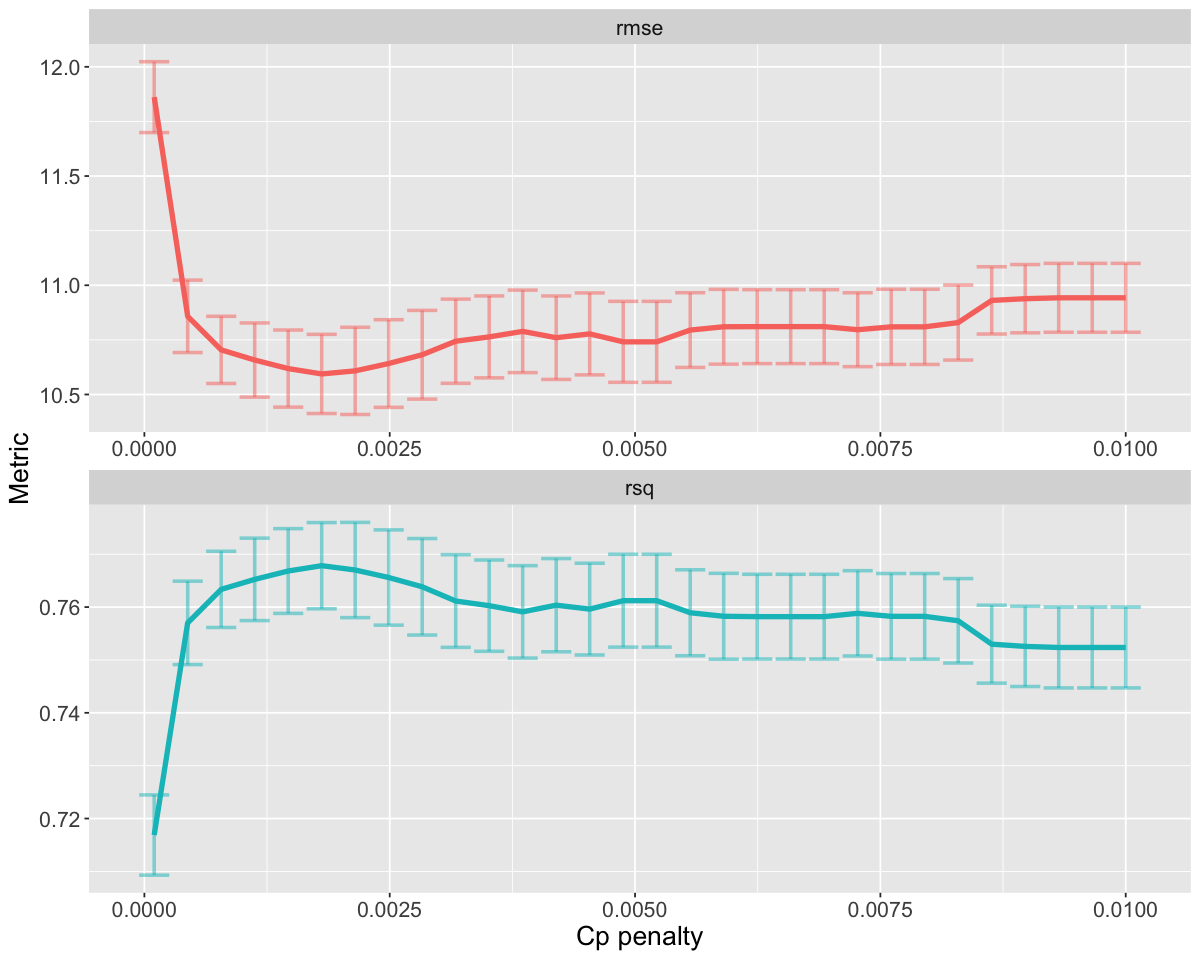

In [591]:
fig(10,8)
tree_reg_fit %>%
    collect_metrics() %>%
    ggplot(aes(cost_complexity, mean, color = .metric)) +
    geom_errorbar(aes(ymin = mean - std_err,
                      ymax = mean + std_err), alpha = 0.5, size=1) +
    geom_line(size = 1.5) +
    facet_wrap(~.metric, scales = "free", nrow = 2) +
    #scale_x_log10() +
    labs(x='Cp penalty', y='Metric') +
    theme(legend.position = "none",
          text=element_text(size=16))

In [594]:
tree_reg_best <- tree_reg_fit %>%
    select_best(metric="rmse")
    #select_by_one_std_err(metric="rmse", penalty)

In [454]:
library(xtable)
options(xtable.floating = FALSE)
options(xtable.timestamp = "")
lin_reg_wf %>% 
    finalize_workflow(lin_reg_best) %>%
    fit(songs_reg_train) %>%
    pull_workflow_fit() %>%
    tidy() %>%
    filter(abs(estimate) > 0) %>%
    select(term, estimate) %>%
    xtable(type = "latex") %>%
print(file = "lm.tex")

In [1208]:
tree_reg_best_fit <- tree_reg_wf %>% 
    finalize_workflow(tree_reg_best) %>%
    fit(data=songs_reg_train)

tree_reg_results <- tree_reg_best_fit %>%
    predict(new_data = songs_reg_test) %>%
    bind_cols(testing(reg_data_split), .) %>%
    threshold_pred()

In [700]:
pred_count <- tree_reg_results %>% 
    count(.pred) %>%
    bind_cols(tree_reg_results %>%
                  group_by(.pred) %>%
                  summarise(min_pop = min(popularity)) %>% 
                  select(min_pop)) %>%
    arrange(.pred)

x_labs <- paste('(N=', pred_count$n, ')', sep='')

In [1194]:
#tree_reg_results %>%
    mutate(D=ifelse(.pred<20, TRUE, FALSE)) %>%
    mutate(C=ifelse(.pred<40 & .pred>=20, TRUE, FALSE)) %>%
    mutate(B=ifelse(.pred<60 & .pred>=40, TRUE, FALSE)) %>%
    mutate(A=ifelse(.pred>=60, TRUE, FALSE)) %>%
    pivot_longer(cols=D:A, names_to = '.pred_class', values_to='dummy') %>%
    filter(dummy) %>%
    select(!dummy)


ERROR: Error: Failed to create output due to bad names.
* Choose another strategy with `names_repair`


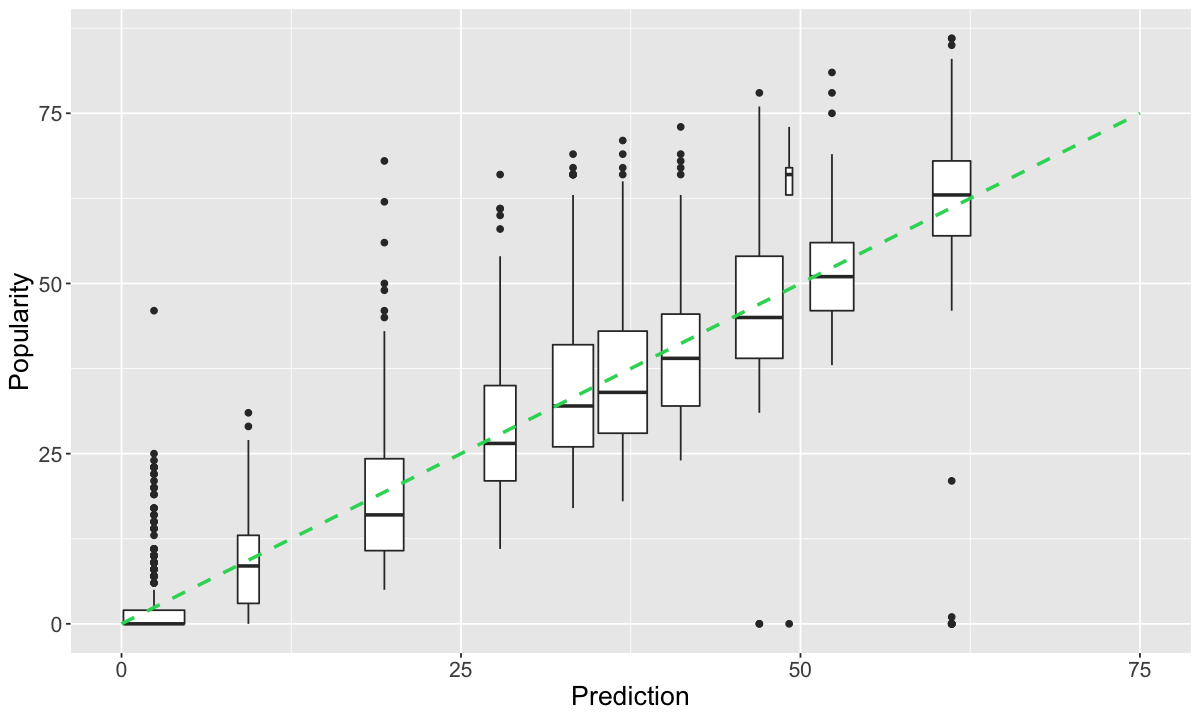

In [1293]:
max_pop <- 75
fig(10,6)
tree_reg_results %>%
    #mutate(.pred=pmax(pmin(.pred, 100), 0)) %>%
    ggplot(aes(.pred, popularity)) + 
    geom_boxplot(aes(group=.pred), width=5, position='identity', varwidth=TRUE) +
    annotate('line', x = c(0,max_pop), y = c(0,max_pop), color='#2FD565', size=1, linetype='dashed') +
    #annotate('text', x=pred_count$.pred, y=pred_count$min_pop-2, label=x_labs)
    scale_x_continuous(limits=c(0, max_pop), breaks=25*c(0:3)) +
    labs(x='Prediction', y='Popularity') +
    theme(text=element_text(size=16))

.metric  .estimator .estimate
1 accuracy multiclass 0.7088544

.metric .estimator .estimate
1 rmse    standard   10.41923

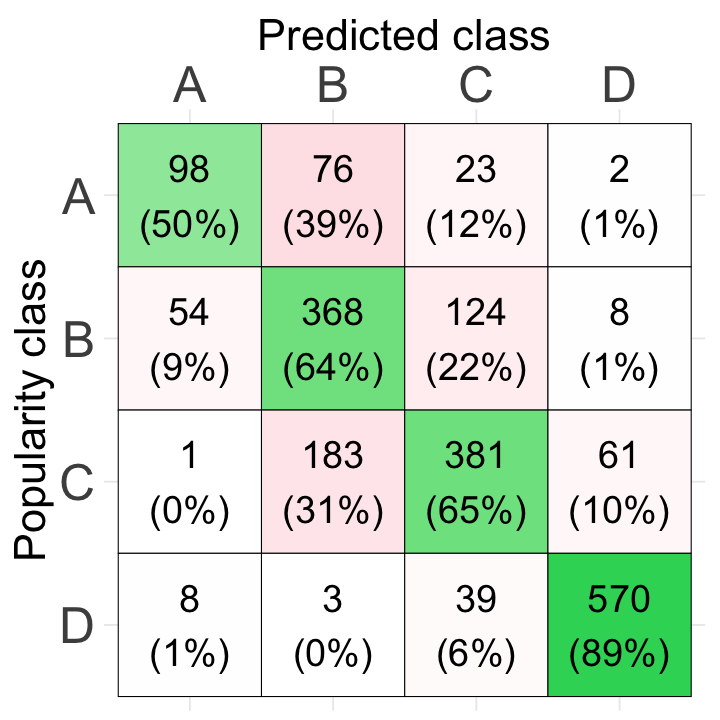

In [1242]:
fig(6,6)
plot_conf_mat(tree_reg_results)

tree_reg_results %>%
    yardstick::accuracy(pop.class, .pred_class)

tree_reg_results %>%
    yardstick::rmse(popularity, .pred)

Warning message:
“Cannot retrieve the data used to build the model (so cannot determine roundint and is.binary for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


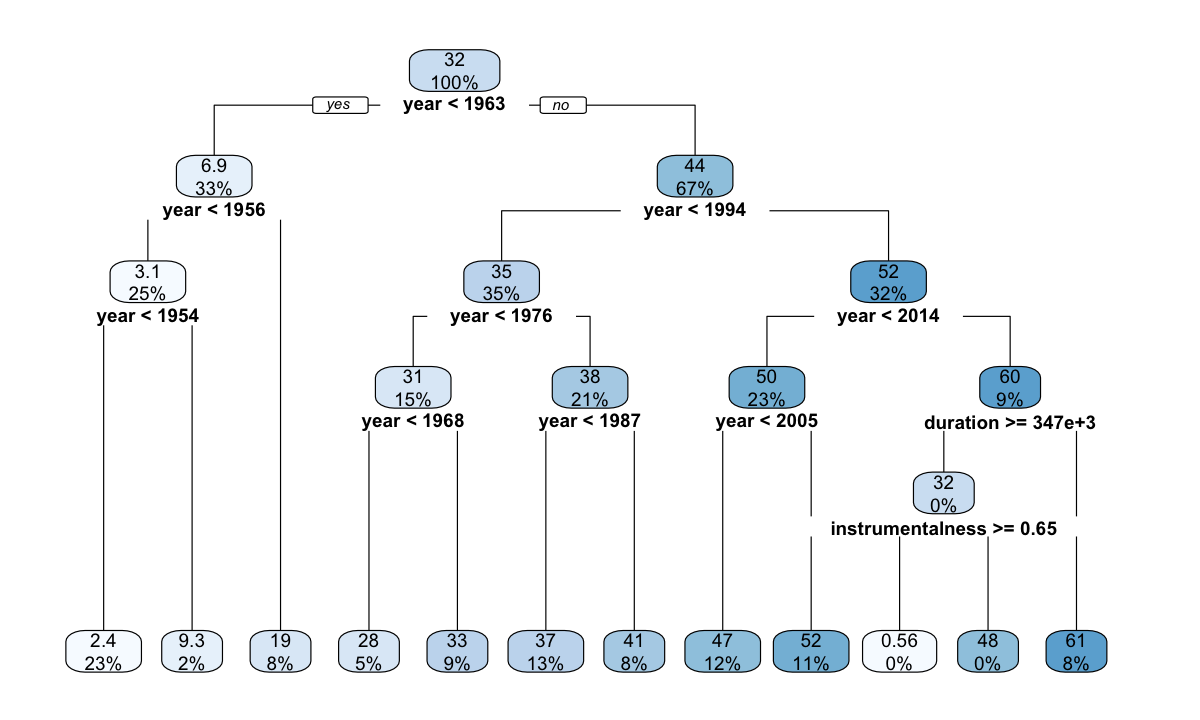

In [1211]:
library(rpart.plot)
fig(10,6)
rpart.plot(tree_reg_best_fit$fit$fit$fit)

In [1214]:
nn_reg_rec <- recipe(popularity ~ ., data = songs_reg_train) %>%
    step_normalize(all_numeric(), -all_outcomes()) %>%
    step_dummy(all_nominal(), -all_outcomes())

nn_reg_mod <- mlp(hidden_units = 16, activation='relu', penalty=0.01, epochs=200) %>%
    set_mode("regression") %>%
    set_engine("keras", verbose=2)

nn_reg_wf <- workflow() %>%
    add_recipe(nn_reg_rec) %>%
    add_model(nn_reg_mod)

In [1215]:
nn_reg_mod_fit <- nn_reg_wf %>%
    fit(data=songs_reg_train)

In [1216]:
nn_reg_mod_results <- nn_reg_mod_fit %>%
    predict(new_data = songs_reg_test) %>%
    bind_cols(testing(reg_data_split), .) %>%
    threshold_pred()

.metric .estimator .estimate
1 rmse    standard   10.58837

.metric  .estimator .estimate
1 accuracy multiclass 0.6913457

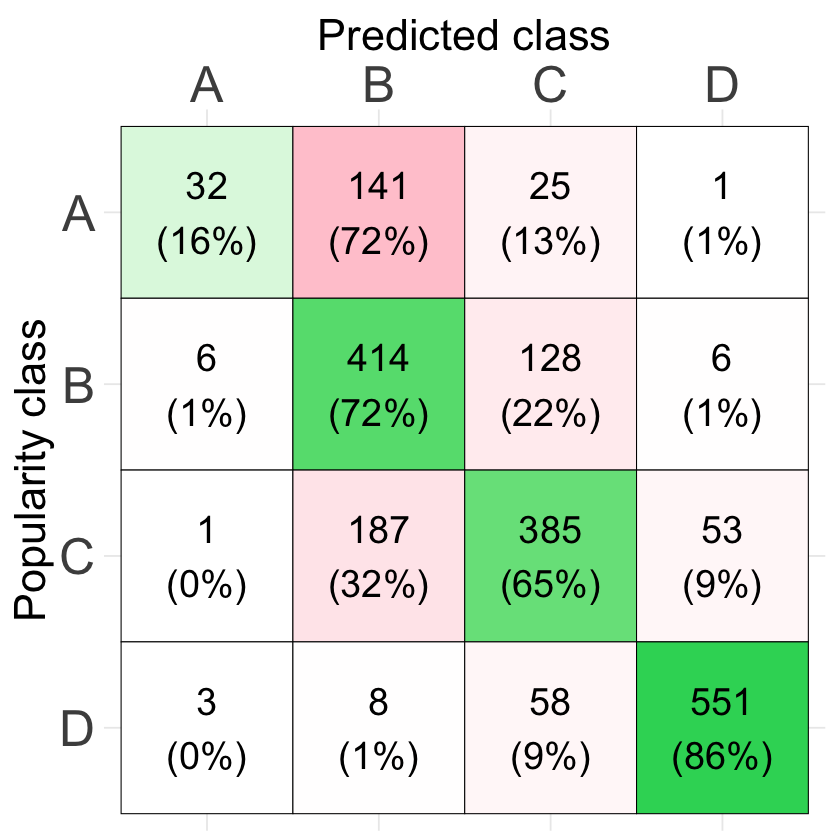

In [1223]:
nn_reg_mod_results %>%
    yardstick::rmse(popularity, .pred)

nn_reg_mod_results %>%
    yardstick::accuracy(pop.class, .pred_class)
    

plot_conf_mat(nn_reg_mod_results)

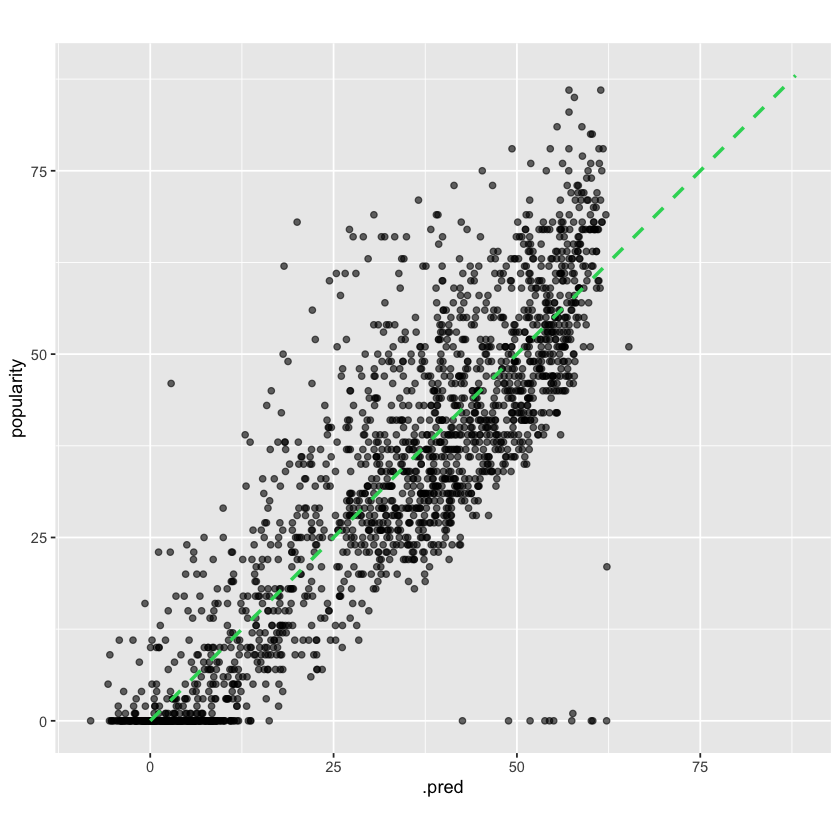

In [1243]:
max_pop <- 88
fig(7,7)
nn_reg_mod_results %>%
    ggplot(aes(.pred, popularity)) + 
    geom_point( alpha=.6) +
    annotate('line', x = c(0, max_pop), y = c(0, max_pop), color='#2FD565', size=1, linetype='dashed') +
    #scale_x_continuous(limits=c(0,100), name='Predicted popularity') +
    #scale_y_continuous(limits=c(0,100), name='Popularity') +
    coord_equal()